<a href="https://colab.research.google.com/github/hawa1983/DATA-612/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Description

The dataset is a subset of the **MovieLens** dataset, a benchmark dataset provided by GroupLens for building and evaluating recommender systems.

It consists of two main components:

1. **`movies` DataFrame**
   This contains metadata about each movie. Each row includes a unique `movieId`, the `title` (e.g., *Toy Story (1995)*), and a pipe-separated list of `genres` (e.g., *Adventure|Animation|Children|Comedy|Fantasy*).

2. **`ratings` DataFrame**
   This captures user interactions. Each entry includes a `userId`, a `movieId` (referring to a movie from the `movies` DataFrame), a numeric `rating` (from 0.5 to 5.0), and a `timestamp` representing when the rating was recorded.

Together, these datasets support both **collaborative filtering** (via user ratings) and **content-based filtering** (via genre metadata).


# Import Required Libraries

In [2]:
# This section imports all necessary libraries for data processing, similarity computation, evaluation, and visualization.
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Exploratory Data Analysis and Implications for Recommender System Design


Unique Users        : 200,948
Unique Movies       : 84,432
Actual Ratings      : 32,000,204
Density of Ratings  : 0.1886%


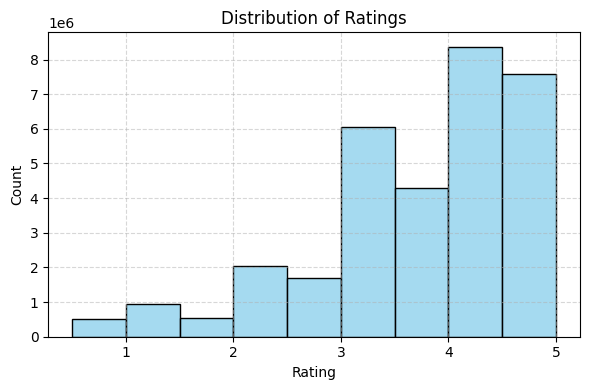

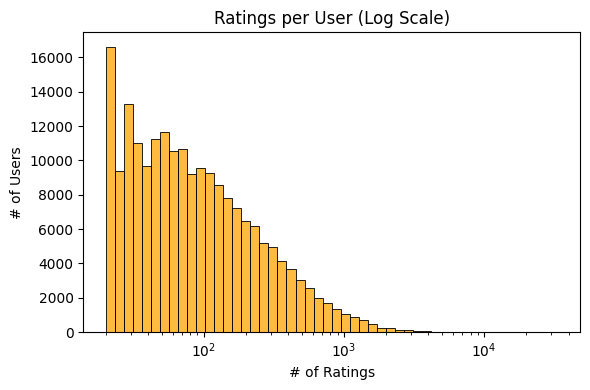

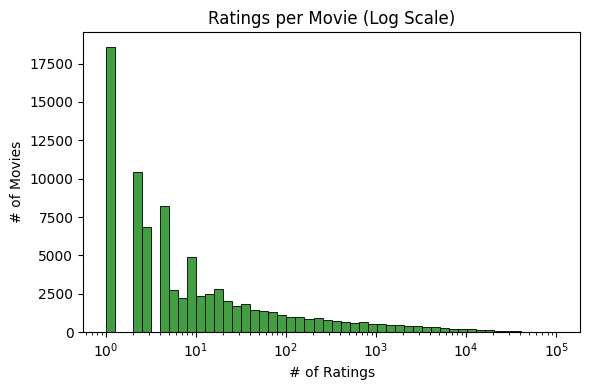

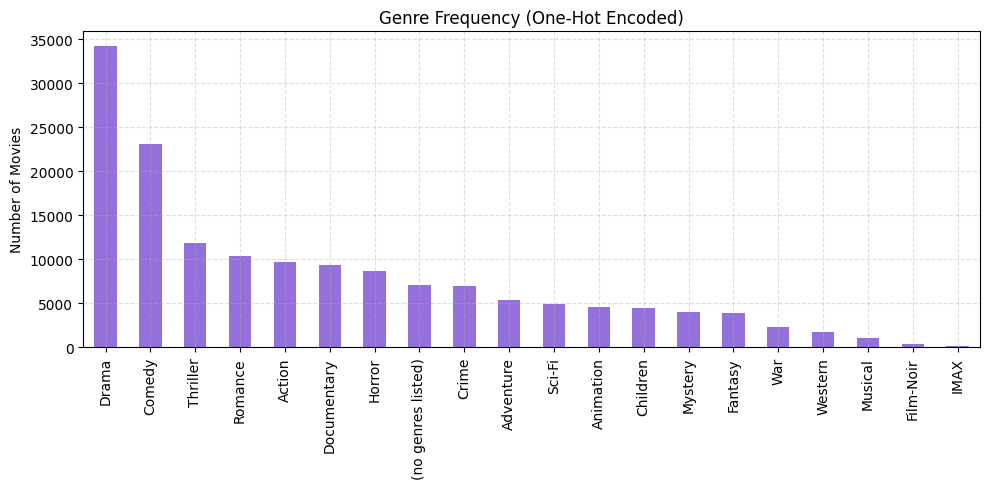

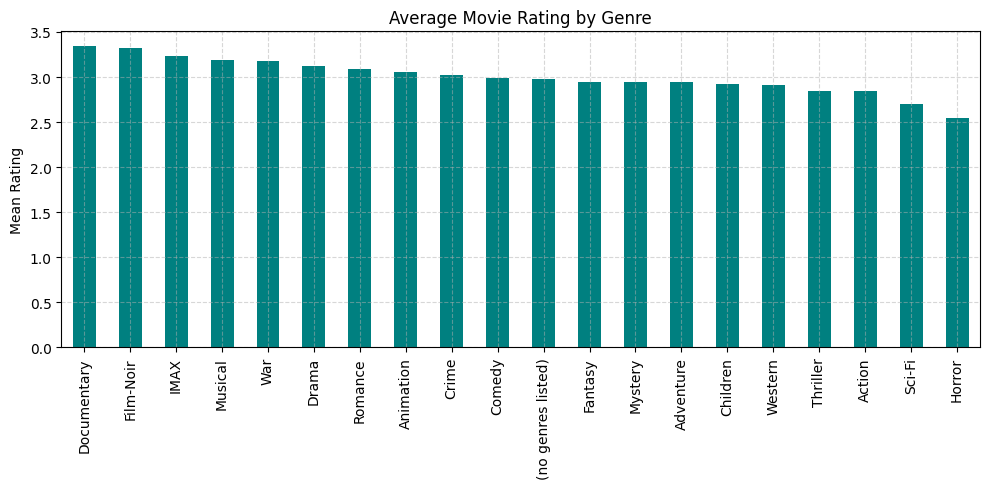

In [1]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load Data ---
ratings = pd.read_csv('/content/ratings.csv')
movies_with_genres = pd.read_csv('/content/movies_with_genres_onehot.csv')

# --- Step 2: Basic Ratings Summary ---
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
actual_ratings = len(ratings)
total_possible_ratings = num_users * num_movies
density = (actual_ratings / total_possible_ratings) * 100

print(f"Unique Users        : {num_users:,}")
print(f"Unique Movies       : {num_movies:,}")
print(f"Actual Ratings      : {actual_ratings:,}")
print(f"Density of Ratings  : {density:.4f}%")

# --- Step 3: Ratings Distribution ---
plt.figure(figsize=(6, 4))
sns.histplot(ratings['rating'], bins=np.arange(0.5, 5.5, 0.5), color='skyblue')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# --- Step 4: Ratings per User ---
user_counts = ratings['userId'].value_counts()
plt.figure(figsize=(6, 4))
sns.histplot(user_counts, bins=50, log_scale=True, color='orange')
plt.title("Ratings per User (Log Scale)")
plt.xlabel("# of Ratings")
plt.ylabel("# of Users")
plt.tight_layout()
plt.show()

# --- Step 5: Ratings per Movie ---
movie_counts = ratings['movieId'].value_counts()
plt.figure(figsize=(6, 4))
sns.histplot(movie_counts, bins=50, log_scale=True, color='green')
plt.title("Ratings per Movie (Log Scale)")
plt.xlabel("# of Ratings")
plt.ylabel("# of Movies")
plt.tight_layout()
plt.show()

# --- Step 6: Genre Frequency from One-Hot ---
genre_cols = [col for col in movies_with_genres.columns if col not in ['movieId', 'title']]
genre_freq = movies_with_genres[genre_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
genre_freq.plot(kind='bar', color='mediumpurple')
plt.title("Genre Frequency (One-Hot Encoded)")
plt.ylabel("Number of Movies")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# --- Step 7: Ratings Diversity per Genre ---
# Strategy: Merge genre flags with mean rating per movie
movie_means = ratings.groupby('movieId')['rating'].mean().reset_index()
movie_stats = pd.merge(movie_means, movies_with_genres, on='movieId', how='inner')

# Compute average rating per genre
genre_rating_avg = {}
for genre in genre_cols:
    genre_rating_avg[genre] = movie_stats[movie_stats[genre] == 1]['rating'].mean()

# Plot
plt.figure(figsize=(10, 5))
pd.Series(genre_rating_avg).sort_values(ascending=False).plot(kind='bar', color='teal')
plt.title("Average Movie Rating by Genre")
plt.ylabel("Mean Rating")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Dataset Overview**

The MovieLens dataset contains:

* 32,000,204 ratings
* 200,948 unique users
* 84,432 unique movies
* User-Movie Matrix Density: 0.1886%

This confirms the dataset is extremely sparse—fewer than 2 out of every 1,000 user-movie pairs have an actual rating. Sparsity is a key challenge for recommender systems.

**Rating Distribution**

The majority of ratings cluster between 3.0 and 5.0, especially at 4.0, suggesting user positivity bias. Very few 0.5–2.0 ratings were observed.

**2. Genre & Rating Relationships**

Stacked bar plots and heatmaps reveal how ratings are distributed across genres. Drama, Comedy, and Action dominate across all rating levels, especially in the 3.0–4.5 range. These patterns help identify genres with enough data to support collaborative filtering.

**Rating Coverage per Movie**

A long-tail distribution is observed: most movies receive few ratings, while a small group are extremely well-rated (e.g., *Shawshank Redemption*, *Forrest Gump*).

**Rating Coverage per User**

Most users have rated fewer than 100 movies. Only a few users contribute large numbers of ratings, showing heavy-tailed user behavior.

**Top Movies**

Popular titles have over 90,000 ratings, offering a strong base for collaborative filtering.

### Recommender System Suitability Analysis

#### Content-Based Filtering

* Well-suited for this dataset due to extreme sparsity
* Genre metadata is available for every movie
* Limitation: Genre tags may not capture nuanced content (e.g., plot, style, mood)
* Best suited for cold-start scenarios involving new users or items

#### User-User Collaborative Filtering

* Struggles with data sparsity
* Low overlap between users makes similarity scores unreliable
* Performs better for active users with more than 100 ratings
* Suitable for active user communities or filtering power users

#### Item-Item Collaborative Filtering

* More stable than user-based filtering because items remain in the system
* Reusable similarity matrices improve efficiency
* Suffers when co-rating between items is low (as in long-tail items)
* Best for frequently rated or popular items

#### Conclusion and Recommendations

Given the high sparsity, skewed rating distribution, and long-tail item activity:

* A hybrid recommendation system is recommended
* Content-based filtering is essential for handling cold-start problems
* Item-based collaborative filtering should be prioritized over user-based approaches when rating density allows
* Popularity-based or genre-average fallback models should be implemented for sparse edge cases
* Consider extending metadata (e.g., tags, plot descriptions) or adopting matrix factorization models to uncover deeper patterns in sparse user behavior


## Sample and Split the Data

In [3]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter

# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter

# --- Load Datasets ---
ratings = pd.read_csv("ratings.csv")
movies = pd.read_csv("movies.csv")

# --- Merge and Preprocess ---
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')
merged_df['genres'] = merged_df['genres'].fillna('(no genres listed)')

# --- Merge and Preprocess ---
merged_df = pd.merge(ratings, movies, on='movieId', how='inner')
merged_df['genres'] = merged_df['genres'].fillna('(no genres listed)')

# --- Step 1: Filter Active Users and Bin Ratings ---
user_stats = merged_df.groupby('userId').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

active_users = user_stats[user_stats['num_ratings'] >= 100].copy()
active_users['rating_bin'] = pd.qcut(active_users['avg_rating'], q=4, labels=False, duplicates='drop')
active_users = active_users.sort_values(by='num_ratings', ascending=False).head(10000)

# Filter merged_df to active users only
merged_df = merged_df[merged_df['userId'].isin(active_users['userId'])]

# --- Step 2: Genre Weights Based on Rarity ---
all_genres_combined = '|'.join(merged_df['genres'].dropna().values)
genre_counts = Counter(all_genres_combined.split('|'))
genre_weights_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count'])
genre_weights_df['inv_weight'] = genre_weights_df['count'].max() / genre_weights_df['count']
genre_weights_df['norm_weight'] = genre_weights_df['inv_weight'] / genre_weights_df['inv_weight'].sum()
genre_weight_dict = genre_weights_df['norm_weight'].to_dict()

def get_genre_weight(genres, weight_dict):
    for genre in genres.split('|'):
        if genre in weight_dict:
            return weight_dict[genre]
    return 0

# --- Step 3: Sample Movies Based on Genre Weights ---
movie_metadata = merged_df[['movieId', 'title', 'genres']].drop_duplicates()
movie_metadata['weight'] = movie_metadata['genres'].apply(lambda x: get_genre_weight(x, genre_weight_dict))
movie_metadata.dropna(subset=['weight'], inplace=True)

sampled_movies = movie_metadata.sample(n=5000, weights='weight', random_state=42)
sampled_movie_ids = sampled_movies['movieId'].unique()

# --- Step 4: Create Stratified Dataset ---
stratified_df = merged_df[merged_df['movieId'].isin(sampled_movie_ids)].copy()

# Keep users with at least 10 ratings in this subset
rating_density = stratified_df.groupby('userId').size().reset_index(name='num_ratings')
eligible_users = rating_density[rating_density['num_ratings'] >= 10]['userId']
stratified_df = stratified_df[stratified_df['userId'].isin(eligible_users)]

# --- Step 5: Train-Test Split ---
train_ratings, test_ratings = train_test_split(stratified_df, test_size=0.2, random_state=42)

print(train_ratings.shape, test_ratings.shape)

(106266, 6) (26567, 6)


## Filtering Approach for Limited Compute Resources

The data filtering strategy used in this recommender system is directly informed by insights from the exploratory data analysis (EDA):

**1. Filtering to Active Users (≥100 ratings):**
The EDA showed that the majority of users have rated fewer than 100 movies, resulting in sparse and unreliable user profiles. By focusing on the top 10,000 users with the most ratings, the approach ensures sufficient overlap for meaningful similarity calculations, especially important for collaborative filtering methods.

**2. Genre-Based Movie Sampling with Weighted Probabilities:**
Since genres like Drama and Comedy dominate the dataset, uniform sampling would skew the representation toward popular genres. Weighting genres inversely by frequency ensures a more balanced movie selection, introducing genre diversity and improving the model’s generalizability.

**3. Minimum Ratings Per User in Sampled Set:**
To prevent sparsity within each sampled subset, users are retained only if they rate a minimum number of sampled movies (e.g., 5, 10, 15, 20). This ensures that the user-item matrix is sufficiently dense for similarity-based predictions.

**4. Bias Correction in Predictions:**
The rating distribution is positively skewed, with most ratings between 3.0 and 5.0. Incorporating global, user, and item bias corrections helps neutralize systematic rating tendencies, improving prediction accuracy.

**5. Grid-Based Optimization:**
Given the sparse nature of the full matrix (\~0.19% density), the grid search across sample sizes and minimum rating thresholds enables identification of the best-performing configurations while maintaining computational efficiency.

Overall, the filtering strategy is a necessary and effective response to the sparsity, skew, and imbalance revealed during EDA. It improves model reliability and allows for scalable experimentation.


# Collaborative Filtering

## Common Methodology (Excludes Preprocessing)

**Rating Matrix Construction**

* Construct a user-item matrix from the training data, with users as rows, movies as columns, and ratings as values.

**Global and Bias Statistics**

* Compute the global mean rating across all ratings.
* Calculate per-user and per-item average ratings to estimate user bias (tendency to rate higher or lower) and item bias (general popularity or unpopularity).

**Prediction Logic**

* For each (user, item) pair in the test set:

  * If the user or item is missing in the training data, fall back to the global mean or a bias-corrected estimate.
  * Identify items rated by the user that are similar to the target item.
  * Normalize the similarity scores to use them as weights.
  * Compute a weighted sum of rating residuals (difference between user rating and item average).
  * Add this sum to the global mean and apply bias correction from user and item averages.
  * Clip the result within the valid rating scale (e.g., 0.5 to 5.0).

**Parallelized Predictions**

* Apply parallel processing to speed up predictions across the test set using tools like `joblib.Parallel`.

**Evaluation Metrics**

* Assess prediction performance using:

  * RMSE (Root Mean Squared Error)
  * MAE (Mean Absolute Error)
  * R² (Coefficient of Determination)

**Visualization**

* Sample a subset of the results and generate the following plots:

  * Box plot comparing actual vs. predicted rating distributions.
  * KDE plot showing the density of actual and predicted ratings.
  * Residual plot to assess prediction errors.
  * Scatter plot of predicted vs. actual ratings for visual alignment.



### Item-Item Collaborative Filtering

#### 1. Item-Item Collaborative Filtering with Bias Correction

Mechanism:

* Computes cosine similarity between items using user-mean-centered ratings.
* Focuses purely on item similarity and bias correction without additional regularization.
* Ratings are predicted using weighted averages of item residuals adjusted by user and item bias.

Application:

* Works well when there is enough overlap in item ratings across users.
* Ideal when user biases are consistent and rating sparsity is moderate.
* Not suitable for highly sparse datasets or cold-start problems.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 838 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 10438 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 26438 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 26567 out of 26567 | elapsed:  1.4min finished



Performance of Item-Item CF with Bias Correction:
RMSE: 0.9102, MAE: 0.6868, R²: 0.2624


/tmp/ipython-input-8-508716789.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Bias_Corrected': 'purple'})


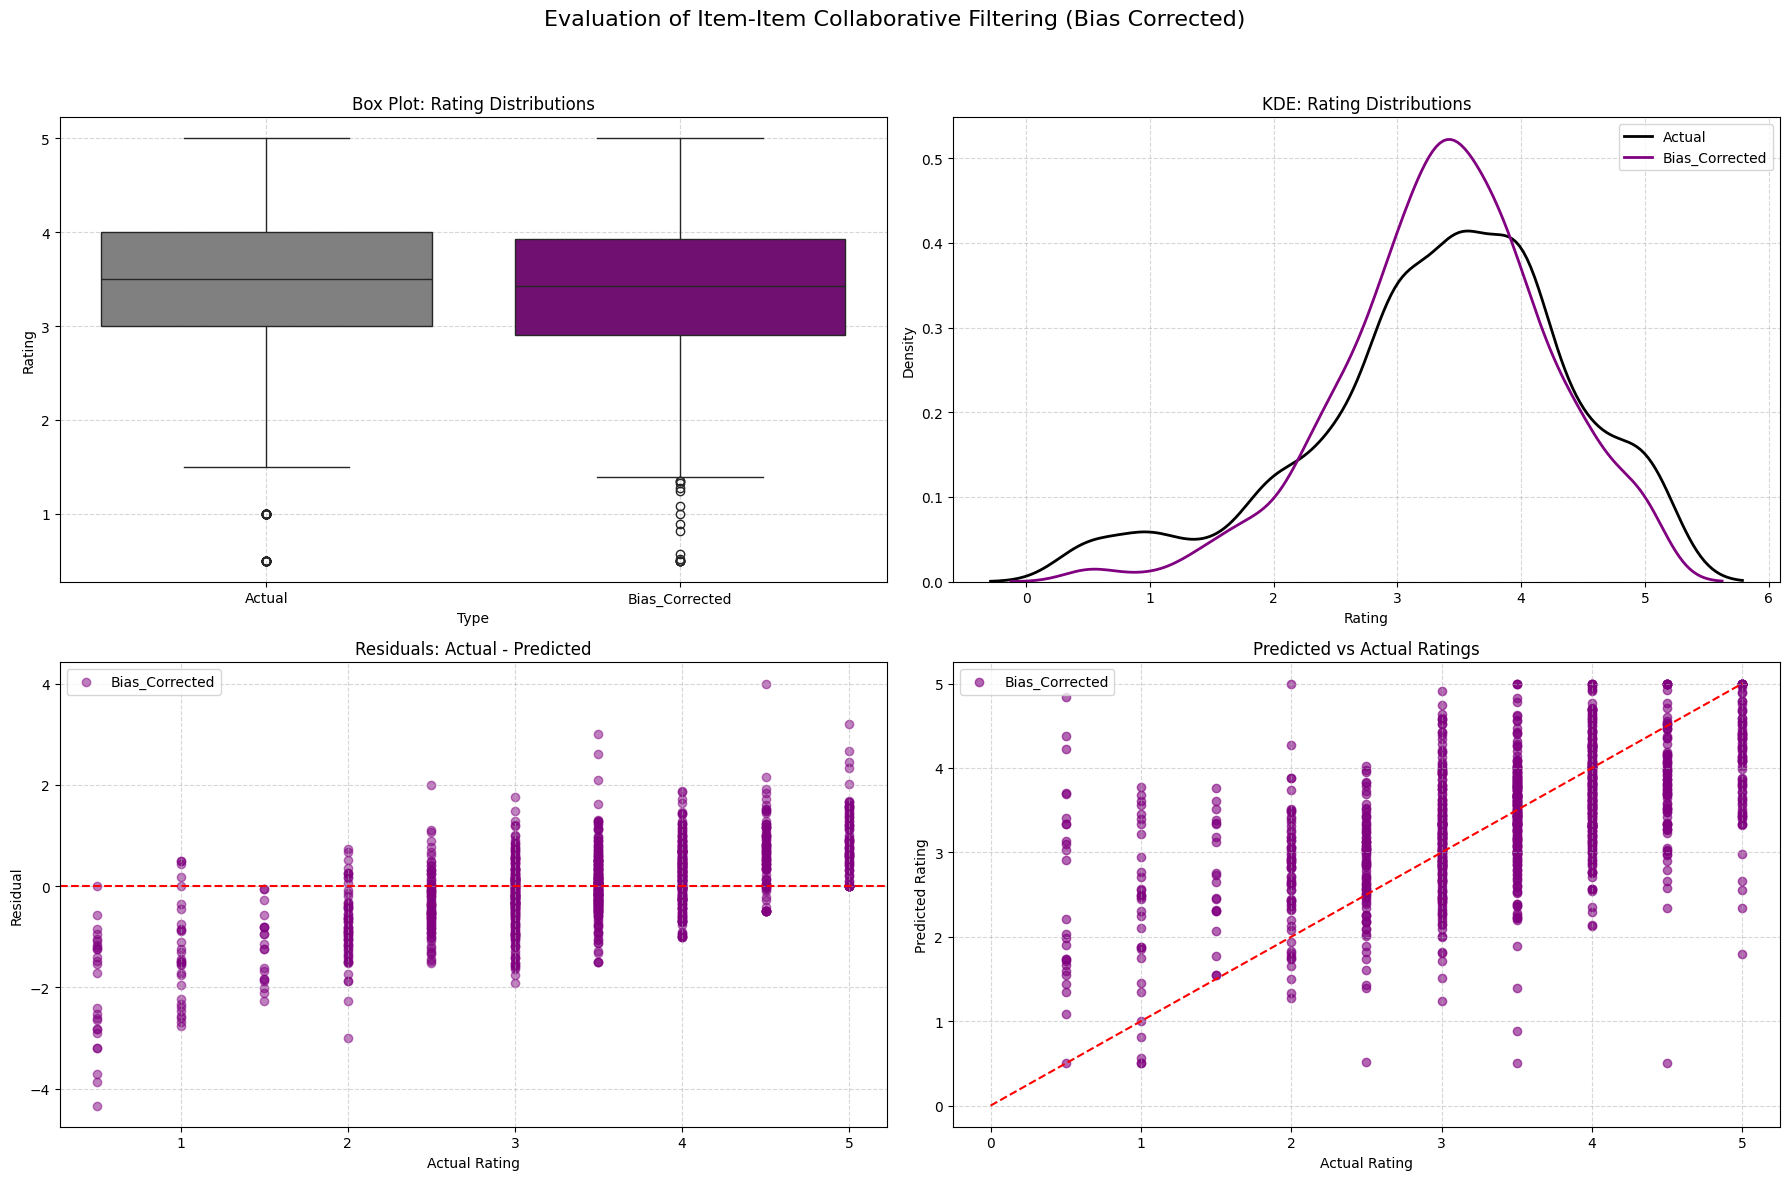

In [8]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Assumes stratified_df and merged_df are pre-loaded ---
stratified_df['genres'] = stratified_df['genres'].fillna('')

# --- Train-Test Split ---
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- One-Hot Genre Matrix ---
movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates()
genre_onehot = movie_genres['genres'].str.get_dummies(sep='|')
genre_onehot.index = movie_genres['movieId']

# --- Rating Stats ---
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Item-Item Similarity Matrix ---
user_item_centered = user_item_matrix.sub(user_item_matrix.mean(axis=1), axis=0)
item_item_sim = pd.DataFrame(
    cosine_similarity(user_item_centered.T.fillna(0)),
    index=user_item_centered.columns,
    columns=user_item_centered.columns
)

# --- Prediction with Bias Correction ---
def predict_item_item_bias_corrected(uid, mid, topn=10):
    if uid not in user_item_matrix.index or mid not in item_item_sim.index:
        return global_mean

    sims = item_item_sim[mid].drop(mid)
    rated_items = user_item_matrix.loc[uid].dropna()
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    if sims.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()
    weighted_sum = (weights * (ratings - item_means[sims.index])).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Generate Predictions ---
from joblib import Parallel, delayed

# --- Wrap the prediction logic ---
def parallel_predict(row):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_item_item_bias_corrected(uid, mid)
    return [uid, mid, actual, pred]

# --- Parallel Execution ---
results = Parallel(n_jobs=-1, backend="loky", verbose=1)(
    delayed(parallel_predict)(row) for _, row in test_ratings.iterrows()
)


viz_df_bias = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Bias_Corrected'])

# --- Evaluation ---
rmse_bias = np.sqrt(mean_squared_error(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected']))
mae_bias = mean_absolute_error(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected'])
r2_bias = r2_score(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected'])

print("\nPerformance of Item-Item CF with Bias Correction:")
print(f"RMSE: {rmse_bias:.4f}, MAE: {mae_bias:.4f}, R²: {r2_bias:.4f}")

# --- Sample for Plotting ---
viz_sample = viz_df_bias.sample(n=min(len(viz_df_bias), 1000), random_state=42).reset_index(drop=True)

# --- Combined Visualization ---
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Evaluation of Item-Item Collaborative Filtering (Bias Corrected)", fontsize=16)

# --- Box Plot ---
box_data = viz_sample[['Actual', 'Bias_Corrected']].melt(var_name='Type', value_name='Rating')
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Bias_Corrected': 'purple'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].set_xlabel('Type')
axs[0, 0].set_ylabel('Rating')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- KDE Plot (reuse yours but embedded here) ---
sns.kdeplot(viz_sample['Actual'], label='Actual', color='black', linewidth=2, ax=axs[0, 1])
sns.kdeplot(viz_sample['Bias_Corrected'], label='Bias_Corrected', color='purple', linewidth=2, ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].set_xlabel('Rating')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Residual Plot ---
residuals = viz_sample['Actual'] - viz_sample['Bias_Corrected']
axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5, color='purple', label='Bias_Corrected')
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].set_xlabel('Actual Rating')
axs[1, 0].set_ylabel('Residual')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# --- Predicted vs Actual Plot ---
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Bias_Corrected'], alpha=0.6, color='purple', label='Bias_Corrected')
axs[1, 1].plot([0, 5], [0, 5], 'r--')  # reference line
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].set_xlabel('Actual Rating')
axs[1, 1].set_ylabel('Predicted Rating')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



***Evaluation of Item-Item Collaborative Filtering with Cosine Similarity and Bias Correction***

The model yields RMSE = 0.9102, MAE = 0.6868, and R² = 0.2624, indicating moderate accuracy with limited variance explained. It handles average ratings reasonably well but struggles with extremes.

The residual and predicted vs. actual plots show consistent overestimation of low ratings and underestimation of high ratings. This pattern is reinforced by the KDE and boxplot, where predicted ratings cluster tightly around the mean, lacking the spread seen in actual ratings. The model regresses toward the mean.

EDA justifies this behavior. The rating distribution is right-skewed, with most values between 3 and 5, inflating item and global means. This leads the model to overpredict for unpopular items and underpredict for highly rated ones. Log-scale histograms show most users and items have few ratings, limiting co-rated overlaps and weakening item similarity estimates. This sparsity causes overly conservative predictions and explains the model’s narrow prediction range and modest R².

Overall, the model’s behavior is aligned with data structure. While functional for mid-range ratings, its effectiveness is constrained by sparsity and reliance on mean-based bias correction. Improvements like shrinkage or hybrid models could address these limitations.


#### 2. IUF-Based Item-Item Collaborative Filtering

Mechanism:

* Introduces Inverse User Frequency (IUF) to penalize popular items that are rated by many users.
* Modifies the user-item matrix by reducing the influence of such items before computing similarities.
* Uses cosine similarity on the IUF-adjusted rating matrix.

Application:

* Useful when certain items dominate the dataset (e.g., top-rated or trending movies).
* Helps reduce popularity bias and improves diversity in recommendations.
* Less beneficial when item rating frequencies are already well-distributed.

/tmp/ipython-input-9-825220127.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'IUF_Bias_Corrected': 'teal'})


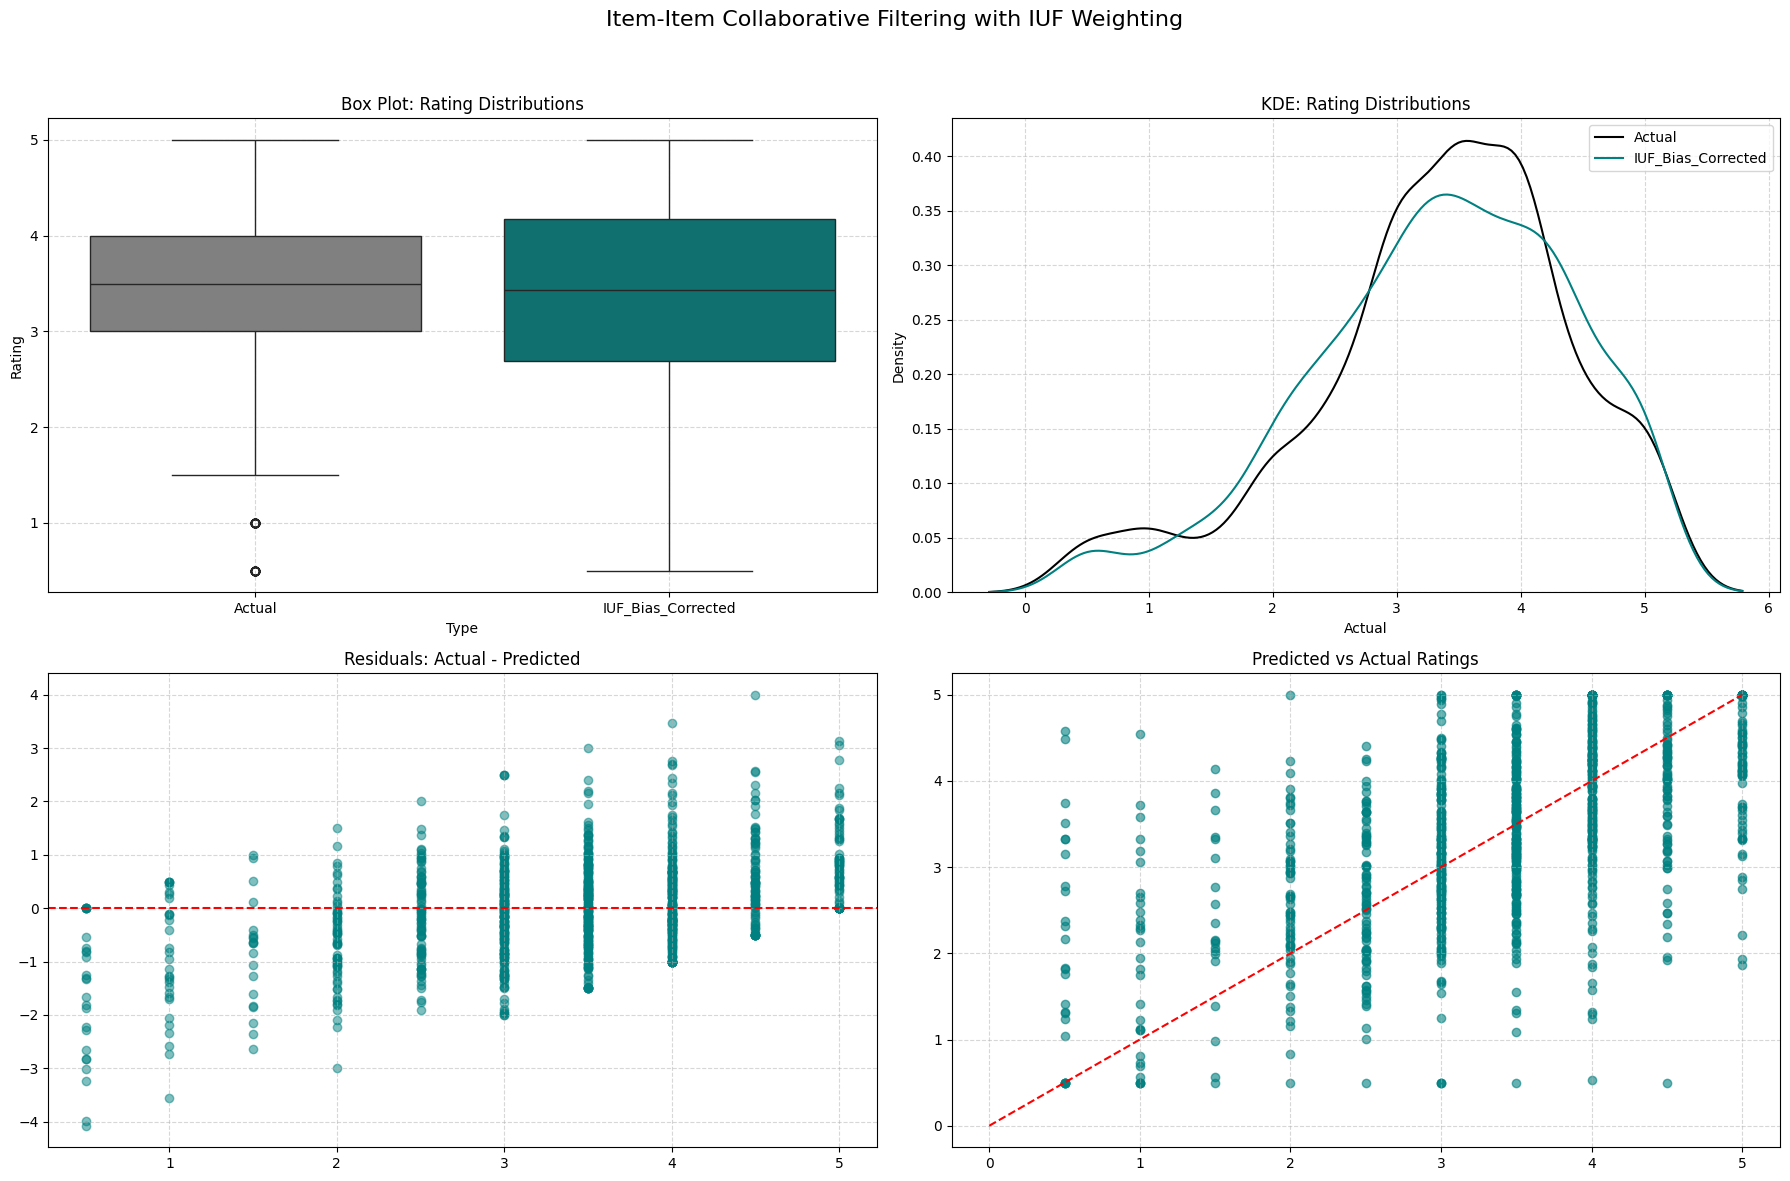


Evaluation Metrics: Item-Item CF with IUF Weighting
RMSE: 1.0186
MAE:  0.7649
R²:   0.0762


In [9]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances, mean_squared_error, mean_absolute_error, r2_score

# --- IUF Weighting Function ---
def apply_iuf_weighting(matrix):
    """
    Apply Inverse User Frequency (IUF) to adjust for popularity bias in items.
    Items rated by many users get down-weighted.

    Parameters:
        matrix: user-item rating matrix (users as rows, items as columns)

    Returns:
        IUF-weighted matrix
    """
    user_counts = (~matrix.isna()).sum(axis=0)  # Count how many users rated each item
    iuf = np.log(matrix.shape[0] / (user_counts + 1e-9))  # Avoid division by 0 using epsilon
    return matrix.multiply(iuf, axis=1)  # Multiply each column (item) by its IUF weight

# --- Preprocessing ---

# Replace missing genre strings with empty strings
stratified_df['genres'] = stratified_df['genres'].fillna('')

# Split dataset into 80% training and 20% test set
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# Create user-item matrix from training data
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# Apply IUF weighting to the user-item matrix
iuf_matrix = apply_iuf_weighting(user_item_matrix)

# Compute item-item cosine similarity matrix using IUF-weighted data
item_item_sim_iuf = 1 - pairwise_distances(iuf_matrix.T.fillna(0), metric='cosine')
item_item_sim_iuf_df = pd.DataFrame(item_item_sim_iuf, index=iuf_matrix.columns, columns=iuf_matrix.columns)

# --- Stats ---

# Global average rating
global_mean = train_ratings['rating'].mean()

# Per-item and per-user average ratings (used for bias adjustment)
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Prediction Function ---
def predict_iuf_item_item(uid, mid):
    """
    Predict a rating using item-item collaborative filtering with IUF and bias correction.

    Parameters:
        uid: user ID
        mid: movie/item ID

    Returns:
        Predicted rating (float)
    """
    # Return global mean if user or item is unknown
    if uid not in user_item_matrix.index or mid not in item_item_sim_iuf_df.index:
        return global_mean

    # Get similarity scores between the target item and all other items (excluding itself)
    sims = item_item_sim_iuf_df[mid].drop(mid)

    # Get all items the user has actually rated
    rated_items = user_item_matrix.loc[uid].dropna()

    # Keep only similarities for items the user has rated
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    # Fallback: if no overlap between rated items and similar items, use bias-corrected baseline
    if sims.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    # Center user ratings by removing item mean (i.e., residuals)
    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()  # Normalize similarities to sum to 1 (handle negative similarities too)
    weighted_sum = (weights * (ratings - item_means[sims.index])).sum()  # Weighted residuals

    # Bias correction using user and item average deviations from global mean
    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    # Final prediction is global mean + biases + residual prediction
    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Generate Predictions ---

from joblib import Parallel, delayed

def predict_row_iuf(row):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_iuf_item_item(uid, mid)
    return [uid, mid, actual, pred]

# Parallel prediction
results_iuf = Parallel(n_jobs=-1)(delayed(predict_row_iuf)(row) for _, row in test_ratings.iterrows())
viz_df_iuf = pd.DataFrame(results_iuf, columns=['userId', 'movieId', 'Actual', 'IUF_Bias_Corrected'])


# Save all predictions to DataFrame
viz_df_iuf = pd.DataFrame(results_iuf, columns=['userId', 'movieId', 'Actual', 'IUF_Bias_Corrected'])

# Take a sample of 1000 rows for visualization purposes
viz_sample_iuf = viz_df_iuf.sample(n=min(len(viz_df_iuf), 1000), random_state=42).reset_index(drop=True)

# --- Visualization ---

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Item-Item Collaborative Filtering with IUF Weighting", fontsize=16)

# --- Box Plot: Compare distribution of actual vs predicted ratings ---
box_data = viz_sample_iuf[['Actual', 'IUF_Bias_Corrected']].melt(var_name='Type', value_name='Rating')
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'IUF_Bias_Corrected': 'teal'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- KDE Plot: Compare density of actual vs predicted ratings ---
sns.kdeplot(viz_sample_iuf['Actual'], label='Actual', color='black', ax=axs[0, 1])
sns.kdeplot(viz_sample_iuf['IUF_Bias_Corrected'], label='IUF_Bias_Corrected', color='teal', ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Residual Plot: Plot residuals (Actual - Predicted) ---
residuals = viz_sample_iuf['Actual'] - viz_sample_iuf['IUF_Bias_Corrected']
axs[1, 0].scatter(viz_sample_iuf['Actual'], residuals, alpha=0.5, color='teal')
axs[1, 0].axhline(0, color='red', linestyle='--')  # Zero-residual reference line
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# --- Scatter Plot: Actual vs Predicted ---
axs[1, 1].scatter(viz_sample_iuf['Actual'], viz_sample_iuf['IUF_Bias_Corrected'], alpha=0.6, color='teal')
axs[1, 1].plot([0, 5], [0, 5], 'r--')  # Diagonal line for perfect predictions
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- Evaluation Metrics ---
# Compute standard evaluation metrics for prediction quality
rmse_iuf = np.sqrt(mean_squared_error(viz_df_iuf['Actual'], viz_df_iuf['IUF_Bias_Corrected']))
mae_iuf = mean_absolute_error(viz_df_iuf['Actual'], viz_df_iuf['IUF_Bias_Corrected'])
r2_iuf = r2_score(viz_df_iuf['Actual'], viz_df_iuf['IUF_Bias_Corrected'])

print("\nEvaluation Metrics: Item-Item CF with IUF Weighting")
print(f"RMSE: {rmse_iuf:.4f}")  # Root Mean Squared Error
print(f"MAE:  {mae_iuf:.4f}")   # Mean Absolute Error
print(f"R²:   {r2_iuf:.4f}")    # R-squared (explained variance)


***Evaluation of Item-Item Collaborative Filtering with IUF Weighting***

The model reports RMSE = 1.0186, MAE = 0.7649, and R² = 0.0762. These are worse than the standard cosine version, indicating that IUF weighting reduced predictive accuracy. The much lower R² suggests the model captures little of the actual rating variance.

While IUF aims to downweight popular items, it may have weakened similarity signals too much, especially in a dataset where popularity often provides the only basis for similarity.

Overall, the model exhibits the same behavior as the standard cosine version but with weaker performance. The adjustment introduced by IUF did not yield a meaningful improvement and may have overcorrected for item popularity.


#### 3. Shrinkage-Aware Item-Item Collaborative Filtering

Mechanism:

* Adjusts raw cosine similarity scores based on co-rating counts.
* Applies a shrinkage factor to reduce the influence of similarities derived from few users.
* The regularization strength is controlled by a constant (λ), balancing similarity magnitude and confidence.

Application:

* Most effective when the dataset is sparse and co-rated item pairs are rare.
* Helps avoid overfitting and noisy predictions from weak item relationships.
* Unnecessary if most item pairs are co-rated by many users.


Evaluation: Item-Item CF with Shrinkage
RMSE: 1.0206
MAE:  0.7663
R²:   0.0727


/tmp/ipython-input-10-3798836063.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz_sample.melt(id_vars=['userId', 'movieId'], value_vars=['Actual', 'Shrinkage_Pred'],


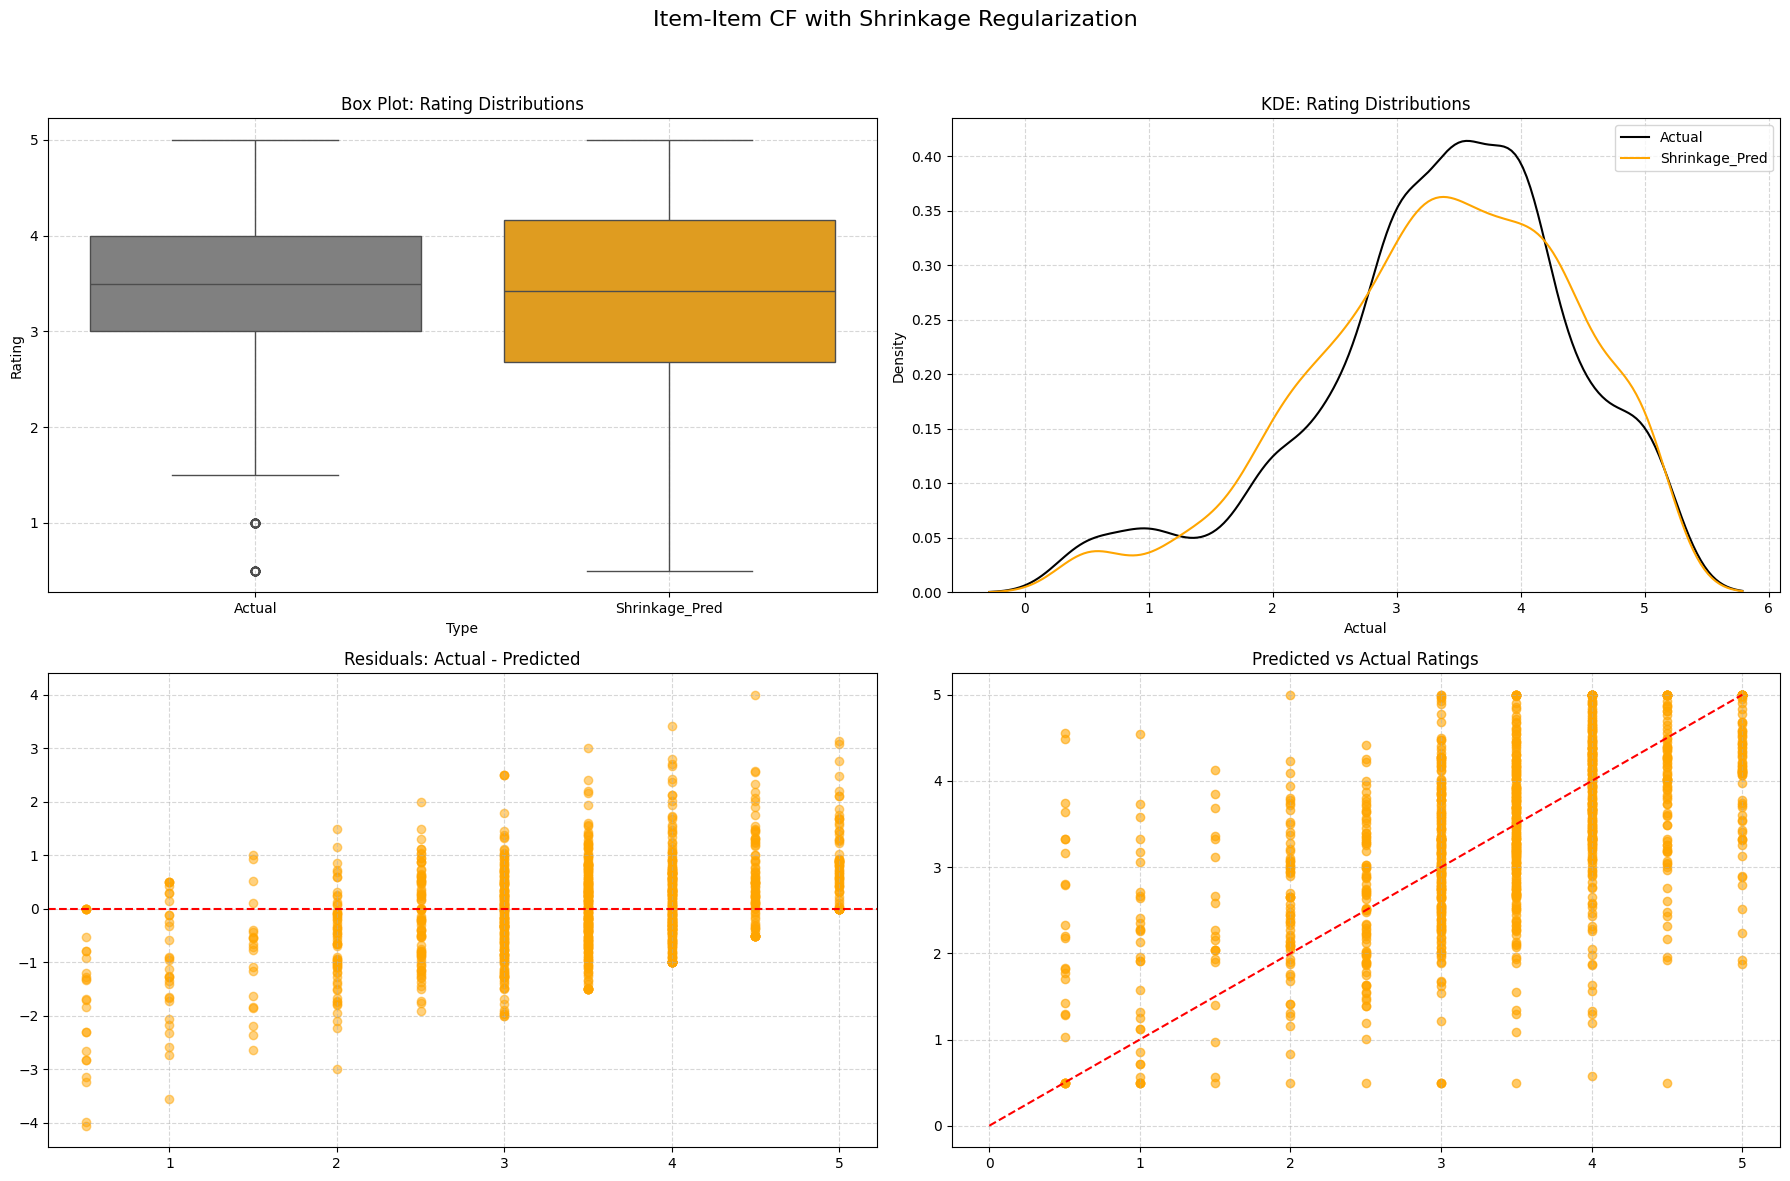

In [10]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load and Preprocess ---
# Replace NaNs in genres column (if applicable)
stratified_df['genres'] = stratified_df['genres'].fillna('')

# Split into training and test sets
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# Create user-item matrix (rows: users, columns: movies)
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Step 2: Compute Shrinkage-Aware Item-Item Similarity Matrix ---
from scipy.sparse import csr_matrix

def compute_shrinkage_similarity_fast(matrix, lambda_val=10):
    """
    Efficient shrinkage-aware cosine similarity using sparse matrix ops.
    """
    # Transpose and binarize the rating presence (1 if not NaN, else 0)
    binary_rated = (~matrix.T.isna()).astype(np.float32)
    sparse_rated = csr_matrix(binary_rated.values)

    # Compute co-rating counts using fast sparse dot product
    co_counts = (sparse_rated @ sparse_rated.T).toarray()

    # Fill missing values for cosine sim calculation
    matrix_filled = matrix.T.fillna(0).values.astype(np.float32)

    # Compute cosine similarity (dense)
    base_similarity = cosine_similarity(matrix_filled)

    # Shrinkage formula
    adjusted_sim = (co_counts / (co_counts + lambda_val)) * base_similarity

    return pd.DataFrame(adjusted_sim, index=matrix.columns, columns=matrix.columns)

item_item_sim_shrink_fast = compute_shrinkage_similarity_fast(user_item_matrix)

# --- Step 3: Compute Rating Statistics for Bias Correction ---
global_mean = train_ratings['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 4: Define Shrinkage-Based Prediction Function ---
def predict_item_item_shrink(uid, mid):
    """
    Predict user rating using item-item CF with shrinkage and bias correction.
    """
    if uid not in user_item_matrix.index or mid not in item_item_sim_shrink_fast.index:
        return global_mean  # Fallback if user or movie is unknown

    sims = item_item_sim_shrink_fast[mid].drop(mid, errors='ignore')  # Similarities to other items
    rated_items = user_item_matrix.loc[uid].dropna()  # Items rated by this user
    sims = sims.loc[sims.index.intersection(rated_items.index)]  # Keep only rated items

    if sims.empty:
        # Fallback to additive user-item bias if no neighbors exist
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()  # Normalize weights
    residuals = ratings - item_means[sims.index]  # Centered ratings
    weighted_sum = (weights * residuals).sum()  # Weighted residual

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 5: Parallel Prediction over Test Set ---
def predict_row(row):
    """Helper for parallel execution."""
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_item_item_shrink(uid, mid)
    return [uid, mid, actual, pred]

results_shrink = Parallel(n_jobs=-1)(delayed(predict_row)(row) for _, row in test_ratings.iterrows())
viz_df_shrink = pd.DataFrame(results_shrink, columns=['userId', 'movieId', 'Actual', 'Shrinkage_Pred'])

# --- Step 6: Evaluation Metrics ---
rmse = np.sqrt(mean_squared_error(viz_df_shrink['Actual'], viz_df_shrink['Shrinkage_Pred']))
mae = mean_absolute_error(viz_df_shrink['Actual'], viz_df_shrink['Shrinkage_Pred'])
r2 = r2_score(viz_df_shrink['Actual'], viz_df_shrink['Shrinkage_Pred'])

print("\nEvaluation: Item-Item CF with Shrinkage")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- Step 7: Visualization ---
viz_sample = viz_df_shrink.sample(n=min(1000, len(viz_df_shrink)), random_state=42)

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Item-Item CF with Shrinkage Regularization", fontsize=16)

# Box Plot
sns.boxplot(data=viz_sample.melt(id_vars=['userId', 'movieId'], value_vars=['Actual', 'Shrinkage_Pred'],
                                  var_name='Type', value_name='Rating'),
            x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Shrinkage_Pred': 'orange'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# KDE Plot
sns.kdeplot(viz_sample['Actual'], label='Actual', color='black', ax=axs[0, 1])
sns.kdeplot(viz_sample['Shrinkage_Pred'], label='Shrinkage_Pred', color='orange', ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# Residual Plot
residuals = viz_sample['Actual'] - viz_sample['Shrinkage_Pred']
axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5, color='orange')
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# Scatter: Predicted vs Actual
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Shrinkage_Pred'], alpha=0.6, color='orange')
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


***Evaluation of Item-Item Collaborative Filtering with Shrinkage Regularization***

The model yields RMSE = 1.0206, MAE = 0.7663, and R² = 0.0727—slightly worse than the standard cosine similarity model (RMSE = 0.9102, MAE = 0.6868, R² = 0.2624). This indicates shrinkage did not improve predictive performance in this case.

Visual patterns remain nearly identical: predictions are biased toward the mean, leading to overestimation of low ratings and underestimation of high ones. This is confirmed across residuals, KDE, boxplot, and predicted vs. actual plots, just as in the cosine model.

The EDA context supports this similarity. Sparse co-rating patterns and heavily skewed rating distributions persist, which shrinkage cannot fully overcome. While shrinkage normally helps reduce overconfident similarity in low-overlap regions, it may have further dampened useful signals in an already sparse setting, contributing to the slightly lower R².

In summary, shrinkage regularization did not yield gains over standard cosine similarity. Both models exhibit similar limitations, but cosine outperforms slightly in this case.


#### 4. Item-Item Collaborative Filtering Using Pearson Correlation Similarity

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 4956 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 12956 tasks      | elapsed:   51.7s
[Parallel(n_jobs=-1)]: Done 24156 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 26564 out of 26567 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 26567 out of 26567 | elapsed:  1.8min finished



Performance of Item-Item CF with Bias Correction (Correlation-Based):
RMSE: 1.0043, MAE: 0.7557, R²: 0.1020


/tmp/ipython-input-12-3096565273.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Bias_Corrected': 'blue'})


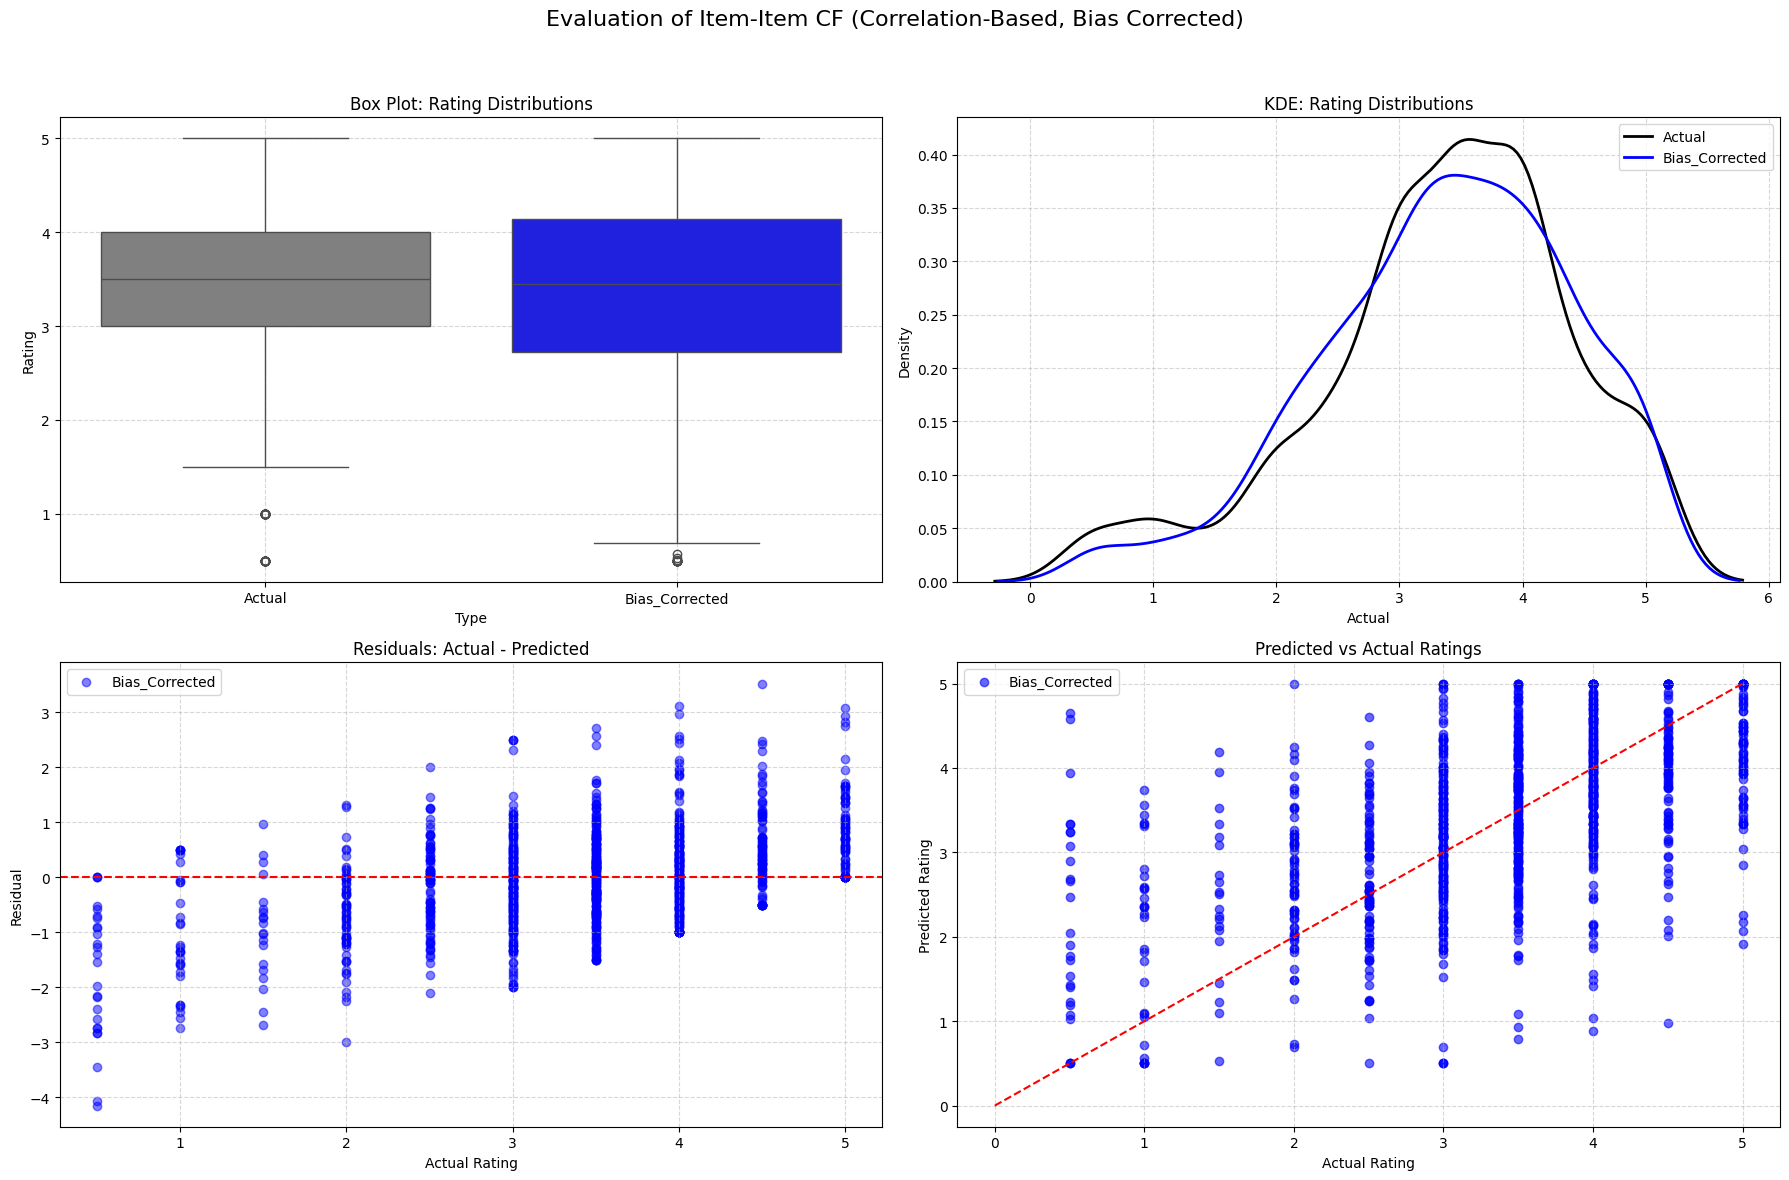

In [12]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed

# --- Assumes stratified_df and merged_df are pre-loaded ---
stratified_df['genres'] = stratified_df['genres'].fillna('')

# --- Train-Test Split ---
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- One-Hot Genre Matrix ---
movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates()
genre_onehot = movie_genres['genres'].str.get_dummies(sep='|')
genre_onehot.index = movie_genres['movieId']

# --- Rating Stats ---
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Item-Item Similarity Matrix using Pearson Correlation ---
item_item_sim = user_item_matrix.corr(method='pearson', min_periods=5)

# --- Prediction with Bias Correction ---
def predict_item_item_bias_corrected(uid, mid, topn=10):
    if uid not in user_item_matrix.index or mid not in item_item_sim.index:
        return global_mean

    sims = item_item_sim[mid].drop(mid)
    rated_items = user_item_matrix.loc[uid].dropna()
    sims = sims.loc[sims.index.intersection(rated_items.index)]

    if sims.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    ratings = rated_items[sims.index]
    weights = sims / sims.abs().sum()
    weighted_sum = (weights * (ratings - item_means[sims.index])).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Generate Predictions ---
def parallel_predict(row):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_item_item_bias_corrected(uid, mid)
    return [uid, mid, actual, pred]

results = Parallel(n_jobs=-1, backend="loky", verbose=1)(
    delayed(parallel_predict)(row) for _, row in test_ratings.iterrows()
)

viz_df_bias = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Bias_Corrected'])

# --- Evaluation ---
rmse_bias = np.sqrt(mean_squared_error(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected']))
mae_bias = mean_absolute_error(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected'])
r2_bias = r2_score(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected'])

print("\nPerformance of Item-Item CF with Bias Correction (Correlation-Based):")
print(f"RMSE: {rmse_bias:.4f}, MAE: {mae_bias:.4f}, R²: {r2_bias:.4f}")

# --- Visualization ---
viz_sample = viz_df_bias.sample(n=min(len(viz_df_bias), 1000), random_state=42).reset_index(drop=True)

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Evaluation of Item-Item CF (Correlation-Based, Bias Corrected)", fontsize=16)

# Box Plot
box_data = viz_sample[['Actual', 'Bias_Corrected']].melt(var_name='Type', value_name='Rating')
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Bias_Corrected': 'blue'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# KDE Plot
sns.kdeplot(viz_sample['Actual'], label='Actual', color='black', linewidth=2, ax=axs[0, 1])
sns.kdeplot(viz_sample['Bias_Corrected'], label='Bias_Corrected', color='blue', linewidth=2, ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# Residual Plot
residuals = viz_sample['Actual'] - viz_sample['Bias_Corrected']
axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5, color='blue', label='Bias_Corrected')
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].set_xlabel('Actual Rating')
axs[1, 0].set_ylabel('Residual')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# Predicted vs Actual
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Bias_Corrected'], alpha=0.6, color='blue', label='Bias_Corrected')
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].set_xlabel('Actual Rating')
axs[1, 1].set_ylabel('Predicted Rating')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


***Evaluation of Item-Item Collaborative Filtering with Correlation Similarity***

The model achieves RMSE = 1.0043, MAE = 0.7557, and R² = 0.1020. Performance is slightly worse than standard cosine similarity (RMSE = 0.9102, MAE = 0.6868, R² = 0.2624).

Visual patterns are nearly identical: predictions regress toward the mean, overestimating low ratings and underestimating high ones. KDE, boxplot, residuals, and predicted vs. actual plots all confirm this.

As with the cosine model, sparsity and skewed rating distributions explain the behavior. Correlation similarity does not mitigate this issue and performs slightly worse, likely due to its sensitivity to variance and smaller co-rating sets.

In summary, correlation-based similarity behaves similarly to cosine but with weaker results in this case. Cosine remains the better option for this dataset.


#### 4. Hybrid Recommender (Content-Based + User-Based Collaborative)

Mechanism:

* Content-Based:

  * Builds user profiles using genre vectors of movies they’ve rated, weighted by centered ratings.
  * Computes cosine similarity between user profile and target movie's genre vector.
  * Applies item bias correction to improve predictions.

* Collaborative:

  * Uses cosine similarity between users based on mean-centered rating patterns.
  * Predicts ratings by aggregating ratings from similar users for a given item.

* Hybrid Blending:

  * Combines content-based and collaborative predictions using a blending factor α.
  * α is tuned (e.g., by minimizing RMSE) to find the optimal mix between the two components.

Application:

* Best suited for sparse rating data enriched with reliable item metadata (e.g., genres).
* Particularly helpful for cold-start scenarios or when users rate movies across diverse genres.
* Less effective if genre information is limited, noisy, or inconsistent.



Performance Comparison:

                 RMSE     MAE      R2
Content-Based  0.9978  0.7692  0.1135
Collaborative  2.0539  1.7370 -2.7557
Hybrid         0.9978  0.7692  0.1135


/tmp/ipython-input-11-1398147813.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Hybrid_Pred': 'purple'})


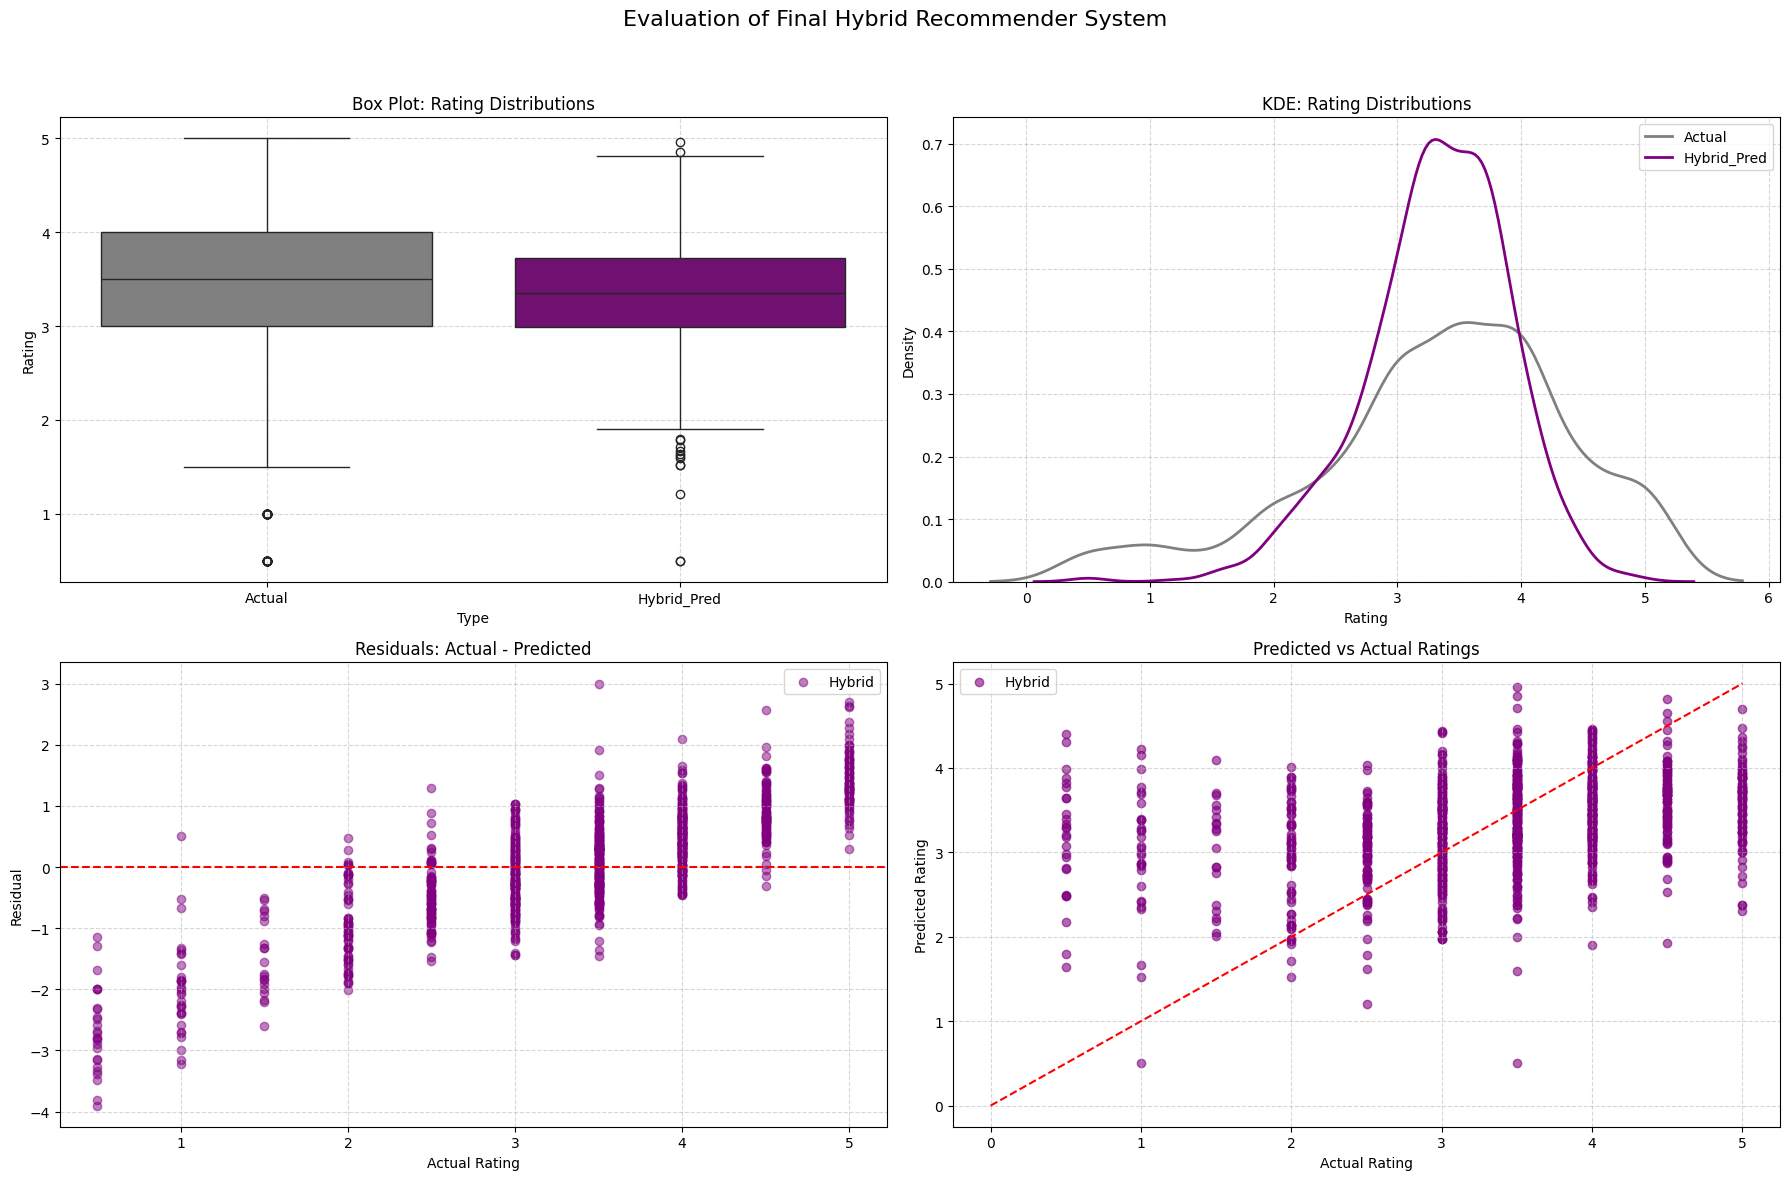

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Genre One-Hot Encoding ---
# Convert genre strings into binary vectors (multi-hot) where each genre is a separate column
movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates()
genre_onehot = movie_genres['genres'].str.get_dummies(sep='|')
genre_onehot.index = movie_genres['movieId']  # Set movieId as index for easy lookup

# --- Step 2: Compute Rating Statistics ---
# Create a matrix where rows are users, columns are movies, and values are ratings
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# Compute global average rating across all training data
global_mean = train_ratings['rating'].mean()

# Compute average rating per movie and per user
movie_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 3: Content-Based Filtering ---
def build_profile(uid):
    """Build a weighted genre profile for a user based on their rated movies."""
    if uid not in user_movie_matrix.index:
        return None
    ratings = user_movie_matrix.loc[uid].dropna()  # Get movies rated by the user
    genre_vectors = genre_onehot.loc[genre_onehot.index.intersection(ratings.index)]  # Match genres for those movies
    if genre_vectors.empty:
        return None
    weights = ratings - ratings.mean()  # Center ratings to reduce user bias
    return np.dot(weights, genre_vectors) / weights.sum()  # Weighted average genre vector

def predict_cb(uid, mid):
    """Predict rating using content-based filtering."""
    if uid not in user_movie_matrix.index or mid not in genre_onehot.index:
        return global_mean  # Fallback for unknown user or movie
    profile = build_profile(uid)
    if profile is None:
        return movie_means.get(mid, global_mean)  # Fallback if profile can't be built
    vec = genre_onehot.loc[mid].values  # Genre vector for the movie
    # Compute cosine similarity between user profile and movie vector
    sim = np.dot(profile, vec) / (np.linalg.norm(profile) * np.linalg.norm(vec))
    sim = 0 if np.isnan(sim) else sim  # Handle invalid values
    bias = movie_means.get(mid, global_mean) - global_mean  # Adjust for item bias
    return np.clip(global_mean + bias + sim * 1.0, 0.5, 5.0)  # Final prediction clipped to rating scale

# --- Step 4: User-Based Collaborative Filtering ---
# Fill missing ratings with 0 (not ideal, but needed for similarity computation)
user_item_matrix = user_movie_matrix.fillna(0)

# Center user ratings to remove user bias
user_means_centered = user_movie_matrix.sub(user_movie_matrix.mean(axis=1), axis=0).fillna(0)

# Compute cosine similarity between users based on centered ratings
sim_matrix = cosine_similarity(user_means_centered)
sim_df = pd.DataFrame(sim_matrix, index=user_means_centered.index, columns=user_means_centered.index)

def predict_cf(uid, mid):
    """Predict rating using collaborative filtering."""
    if uid not in user_movie_matrix.index or mid not in user_movie_matrix.columns:
        return global_mean  # Fallback for unknown user or movie
    sims = sim_df.loc[uid]  # Similarity vector for user
    ratings = user_movie_matrix[mid]  # Ratings for movie
    mask = ratings.notna()  # Only include users who rated the movie
    if not mask.any():
        return global_mean
    sims = sims[mask]  # Similar users
    ratings = ratings[mask]
    if sims.abs().sum() == 0:
        return global_mean  # Avoid division by zero
    pred = np.dot(sims, ratings) / sims.abs().sum()  # Weighted average of neighbor ratings
    return np.clip(pred, 0.5, 5.0)

# --- Step 5: Parallel Predictions on Test Data ---
def predict_row(row):
    """Generate predictions for one user-movie-rating row."""
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    cb_pred = predict_cb(uid, mid)
    cf_pred = predict_cf(uid, mid)
    return [uid, mid, actual, cb_pred, cf_pred]

# Run prediction in parallel for faster computation
results = Parallel(n_jobs=-1)(delayed(predict_row)(row) for _, row in test_ratings.iterrows())

# Collect predictions into DataFrame
hybrid_df = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Content_Pred', 'Collaborative_Pred'])

# --- Step 6: Hybrid Blending of Predictions ---
def blend_predictions(row, alpha):
    """Blend content-based and collaborative predictions using alpha weight."""
    p_cb, p_cf = row['Content_Pred'], row['Collaborative_Pred']
    if pd.isna(p_cb) and pd.isna(p_cf):
        return global_mean
    if pd.isna(p_cb):
        return p_cf
    if pd.isna(p_cf):
        return p_cb
    return alpha * p_cb + (1 - alpha) * p_cf  # Linear blend

def tune_alpha(df, alpha_grid):
    """Find the best alpha blending weight based on RMSE."""
    best_rmse = float('inf')
    best_alpha = None
    for alpha in alpha_grid:
        blended = df.apply(lambda row: blend_predictions(row, alpha), axis=1)
        valid = df['Actual'].notna() & blended.notna()
        rmse = np.sqrt(mean_squared_error(df.loc[valid, 'Actual'], blended[valid]))
        if rmse < best_rmse:
            best_rmse = rmse
            best_alpha = alpha
    return best_alpha

# Try blending weights from 0 to 1 in steps of 0.1
alpha_values = np.linspace(0, 1, 11)
best_alpha = tune_alpha(hybrid_df, alpha_values)

# Apply best blending weight
hybrid_df['Hybrid_Pred'] = hybrid_df.apply(lambda row: blend_predictions(row, best_alpha), axis=1)

# --- Step 7: Evaluation Metrics ---
def compute_metrics(actual, predicted):
    """Compute RMSE, MAE, and R² metrics."""
    return {
        'RMSE': np.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'R2': r2_score(actual, predicted)
    }

# Evaluate each model
metrics_cb = compute_metrics(hybrid_df['Actual'], hybrid_df['Content_Pred'])
metrics_cf = compute_metrics(hybrid_df['Actual'], hybrid_df['Collaborative_Pred'])
metrics_hybrid = compute_metrics(hybrid_df['Actual'], hybrid_df['Hybrid_Pred'])

# Create performance comparison table
performance_matrix = pd.DataFrame([metrics_cb, metrics_cf, metrics_hybrid],
                                  index=['Content-Based', 'Collaborative', 'Hybrid'])

print("\nPerformance Comparison:\n")
print(performance_matrix.round(4))

# --- Step 8: Visualization of Results ---
# Sample a subset for clean plots
viz_sample = hybrid_df.sample(n=min(len(hybrid_df), 1000), random_state=42).reset_index(drop=True)

# Create 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Evaluation of Final Hybrid Recommender System", fontsize=16)

# --- Box Plot of Actual vs Predicted Ratings ---
box_data = viz_sample[['Actual', 'Hybrid_Pred']].melt(var_name='Type', value_name='Rating')
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Hybrid_Pred': 'purple'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].set_xlabel('Type')
axs[0, 0].set_ylabel('Rating')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- KDE Plot of Rating Distributions ---
sns.kdeplot(viz_sample['Actual'], label='Actual', color='gray', linewidth=2, ax=axs[0, 1])
sns.kdeplot(viz_sample['Hybrid_Pred'], label='Hybrid_Pred', color='purple', linewidth=2, ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].set_xlabel('Rating')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Residual Plot (Actual - Predicted) ---
residuals = viz_sample['Actual'] - viz_sample['Hybrid_Pred']
axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5, color='purple', label='Hybrid')
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].set_xlabel('Actual Rating')
axs[1, 0].set_ylabel('Residual')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# --- Predicted vs Actual Plot ---
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Hybrid_Pred'], alpha=0.6, color='purple', label='Hybrid')
axs[1, 1].plot([0, 5], [0, 5], 'r--')  # Diagonal reference line
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].set_xlabel('Actual Rating')
axs[1, 1].set_ylabel('Predicted Rating')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

# Final layout adjustment
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


***Evaluation of Final Hybrid Recommender System***

The hybrid model achieves RMSE = 0.9978, MAE = 0.7692, and R² = 0.1135—identical to the content-based model and significantly better than the collaborative model (RMSE = 2.0539, R² = -2.7557). This indicates that the hybrid simply defaulted to the content-based predictions.

Visuals confirm this. The hybrid system exhibits the same overestimation of low ratings and underestimation of high ones seen in previous models, particularly those regressing toward the mean. KDE, boxplot, residuals, and predicted vs. actual plots closely mirror those of the content-based system.

Given the collaborative model performed poorly, it likely contributed little to the hybrid prediction. As a result, the hybrid system essentially duplicates the content-based output, gaining no measurable advantage.


### User-User Collaborative Filtering

#### 1. User-User Collaborative Filtering Using Cosine Similarity

**Mechanism:**

* Computes cosine similarity between users using item-mean-centered ratings.
* Predicts ratings using a weighted sum of rating residuals, corrected by global, user, and item bias.
* Focuses purely on user similarity and bias correction without additional regularization.

**Application:**

* Effective when users have sufficient overlap in rated items.
* Performs well when item biases are consistent and sparsity is moderate.
* Not suitable for highly sparse datasets or cold-start user scenarios.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 2640 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 6640 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 12240 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 19440 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 26567 out of 26567 | elapsed:  2.9min finished



Performance of User-User CF with Bias Correction:
RMSE: 0.9373, MAE: 0.7099, R²: 0.2178


/tmp/ipython-input-13-1400696571.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Bias_Corrected': 'blue'})


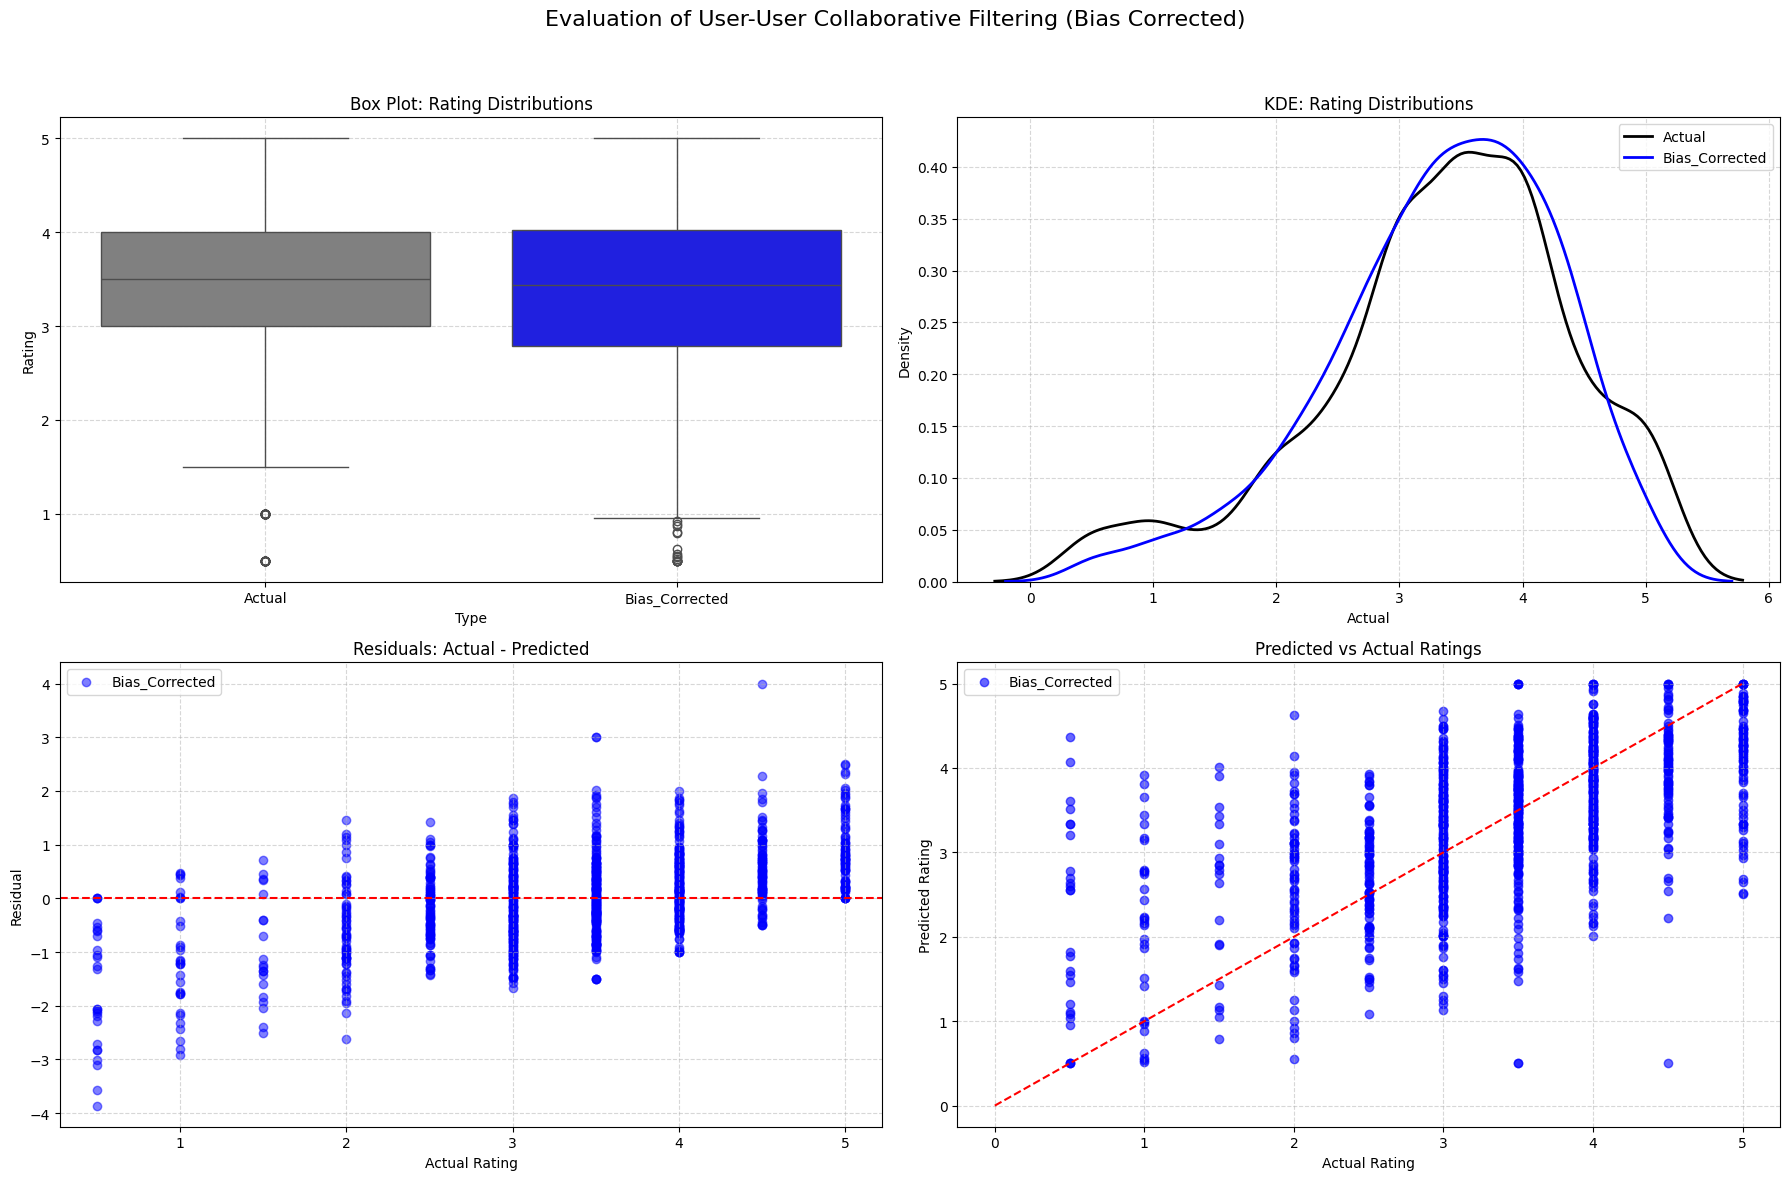

In [13]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed

# --- Assumes stratified_df and merged_df are pre-loaded ---
stratified_df['genres'] = stratified_df['genres'].fillna('')

# --- Train-Test Split ---
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# --- One-Hot Genre Matrix ---
movie_genres = stratified_df[['movieId', 'genres']].drop_duplicates()
genre_onehot = movie_genres['genres'].str.get_dummies(sep='|')
genre_onehot.index = movie_genres['movieId']

# --- Rating Stats ---
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- User-User Similarity Matrix ---
user_item_centered = user_item_matrix.sub(user_item_matrix.mean(axis=1), axis=0)
user_user_sim = pd.DataFrame(
    cosine_similarity(user_item_centered.fillna(0)),
    index=user_item_centered.index,
    columns=user_item_centered.index
)

# --- Prediction with Bias Correction ---
def predict_user_user_bias_corrected(uid, mid, topn=10):
    if mid not in user_item_matrix.columns or uid not in user_user_sim.index:
        return global_mean

    sims = user_user_sim.loc[uid].drop(uid)
    item_ratings = user_item_matrix[mid].dropna()
    sims = sims.loc[sims.index.intersection(item_ratings.index)]

    if sims.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    ratings = item_ratings[sims.index]
    weights = sims / sims.abs().sum()
    weighted_sum = (weights * (ratings - user_means[sims.index])).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Generate Predictions ---
def parallel_predict(row):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_user_user_bias_corrected(uid, mid)
    return [uid, mid, actual, pred]

results = Parallel(n_jobs=-1, backend="loky", verbose=1)(
    delayed(parallel_predict)(row) for _, row in test_ratings.iterrows()
)

viz_df_bias = pd.DataFrame(results, columns=['userId', 'movieId', 'Actual', 'Bias_Corrected'])

# --- Evaluation ---
rmse_bias = np.sqrt(mean_squared_error(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected']))
mae_bias = mean_absolute_error(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected'])
r2_bias = r2_score(viz_df_bias['Actual'], viz_df_bias['Bias_Corrected'])

print("\nPerformance of User-User CF with Bias Correction:")
print(f"RMSE: {rmse_bias:.4f}, MAE: {mae_bias:.4f}, R²: {r2_bias:.4f}")

# --- Sample for Plotting ---
viz_sample = viz_df_bias.sample(n=min(len(viz_df_bias), 1000), random_state=42).reset_index(drop=True)

# --- Combined Visualization ---
fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("Evaluation of User-User Collaborative Filtering (Bias Corrected)", fontsize=16)

# --- Box Plot ---
box_data = viz_sample[['Actual', 'Bias_Corrected']].melt(var_name='Type', value_name='Rating')
sns.boxplot(data=box_data, x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Bias_Corrected': 'blue'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# --- KDE Plot ---
sns.kdeplot(viz_sample['Actual'], label='Actual', color='black', linewidth=2, ax=axs[0, 1])
sns.kdeplot(viz_sample['Bias_Corrected'], label='Bias_Corrected', color='blue', linewidth=2, ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# --- Residual Plot ---
residuals = viz_sample['Actual'] - viz_sample['Bias_Corrected']
axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5, color='blue', label='Bias_Corrected')
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].set_xlabel('Actual Rating')
axs[1, 0].set_ylabel('Residual')
axs[1, 0].legend()
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# --- Predicted vs Actual Plot ---
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Bias_Corrected'], alpha=0.6, color='blue', label='Bias_Corrected')
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].set_xlabel('Actual Rating')
axs[1, 1].set_ylabel('Predicted Rating')
axs[1, 1].legend()
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


***Comparison: User-User CF vs. Item-Item CF***

*User-User CF (Bias-Corrected)*
RMSE: 0.9373
MAE: 0.7099
R²: 0.2178

*Item-Item CF (Cosine, Bias-Corrected)*
RMSE: 0.9102
MAE: 0.6868
R²: 0.2624

**Conclusion**
The item-item model performs better across all metrics—lower RMSE and MAE, and higher R². The difference is modest but consistent.

**Why Item-Item CF performs better:**

* **Stability of Item Profiles:** Items have more consistent behavior patterns than users. Item-item similarities are often more reliable, especially in sparse datasets, because popular items accumulate more co-ratings than individual users.
* **User Sparsity:** Many users rate very few items (confirmed in EDA), weakening user-user similarity calculations. As a result, the user-user model is more sensitive to noise and less able to generalize.

**Visual Comparison:**
Residuals and predicted-vs-actual plots confirm both models exhibit regression to the mean, but the user-user model shows slightly more dispersion and larger residuals, especially for extreme ratings.

In short, item-item CF is slightly more accurate and generalizable in this dataset due to greater reliability in item similarity under sparsity.


#### 2. User-User Collaborative Filtering with Shrinkage Regularization

**Mechanism:**

* Computes cosine similarity between users using their rating vectors.
* Applies **shrinkage regularization** to downweight similarity scores based on the number of co-rated items:

  $$
  \text{adjusted_sim}_{uv} = \left( \frac{n_{uv}}{n_{uv} + \lambda} \right) \cdot \text{cosine_sim}_{uv}
  $$

  where $n_{uv}$ is the number of co-rated items and $\lambda$ is a regularization constant.
* Predicts ratings using a weighted sum of mean-centered residuals from similar users, corrected by global, user, and item bias.

**Application:**

* Useful when many user pairs share only a few co-rated items, which can lead to inflated similarity.
* Improves stability and reduces overfitting in sparse datasets.
* Less beneficial when overlap is already sufficient across users or when users are very inactive (few total ratings).

**Optimized Parameters:**

* **Shrinkage constant $\lambda$**: Controls how aggressively similarity scores are penalized for low co-rating counts (e.g., $\lambda = 10$).
* **Bias terms**: Global mean, user mean, and item mean are used for correcting systemic bias in rating predictions.



Evaluation: User-User CF with Shrinkage
RMSE: 1.0041
MAE:  0.7622
R²:   0.1024


/tmp/ipython-input-14-2896086421.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz_sample.melt(id_vars=['userId', 'movieId'], value_vars=['Actual', 'Shrinkage_Pred'],


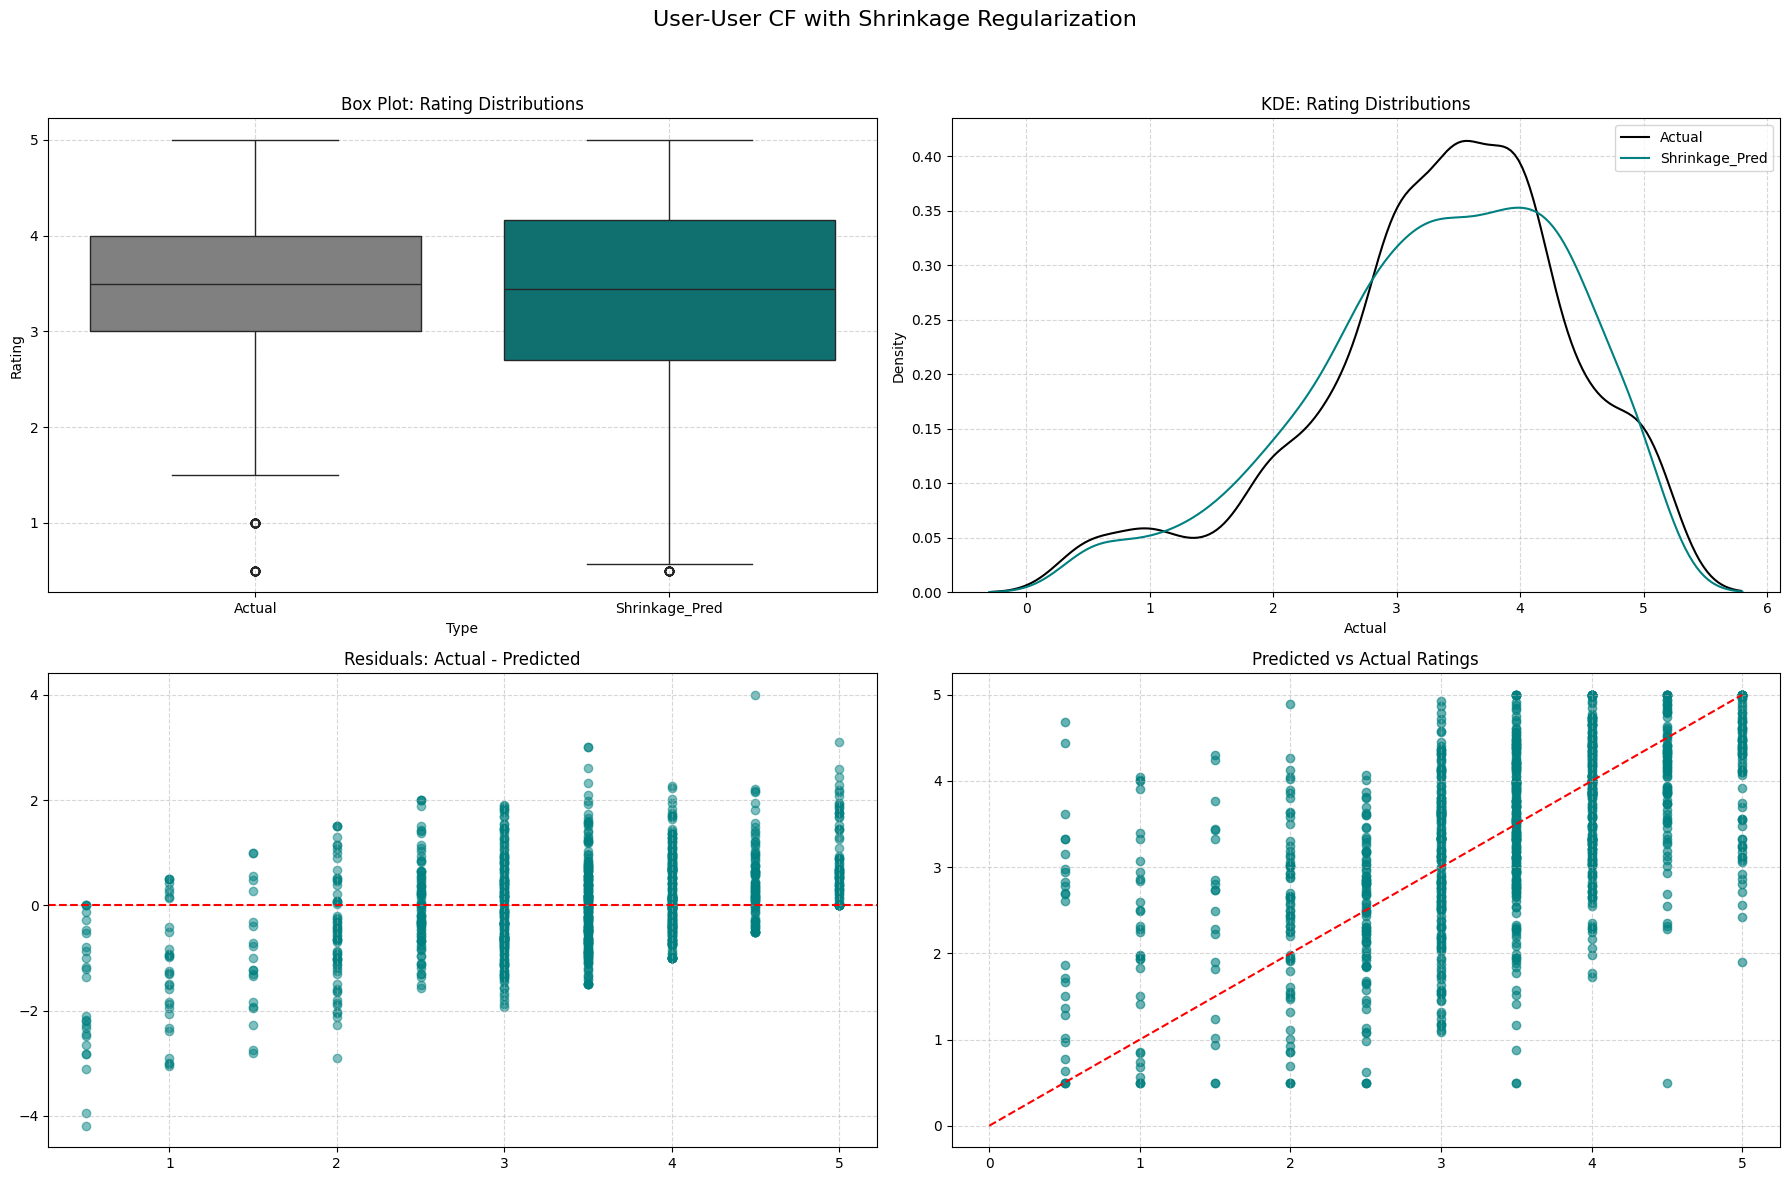

In [14]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

# --- Step 1: Load and Preprocess ---
stratified_df['genres'] = stratified_df['genres'].fillna('')

# Train-Test Split
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# User-Item Matrix
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Step 2: Compute Shrinkage-Aware User-User Similarity Matrix ---
def compute_user_user_shrinkage(matrix, lambda_val=10):
    binary_rated = (~matrix.isna()).astype(np.float32)
    sparse_rated = csr_matrix(binary_rated.values)

    # Compute co-rated item counts
    co_counts = (sparse_rated @ sparse_rated.T).toarray()

    # Fill missing values
    matrix_filled = matrix.fillna(0).values.astype(np.float32)

    # Cosine similarity between users
    base_similarity = cosine_similarity(matrix_filled)

    # Shrinkage-adjusted similarity
    adjusted_sim = (co_counts / (co_counts + lambda_val)) * base_similarity

    return pd.DataFrame(adjusted_sim, index=matrix.index, columns=matrix.index)

user_user_sim_shrink = compute_user_user_shrinkage(user_item_matrix)

# --- Step 3: Compute Statistics for Bias Correction ---
global_mean = train_ratings['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 4: Define Prediction Function ---
def predict_user_user_shrink(uid, mid):
    if mid not in user_item_matrix.columns or uid not in user_user_sim_shrink.index:
        return global_mean

    sims = user_user_sim_shrink.loc[uid].drop(uid, errors='ignore')
    user_ratings = user_item_matrix[mid].dropna()
    sims = sims.loc[sims.index.intersection(user_ratings.index)]

    if sims.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    ratings = user_ratings[sims.index]
    weights = sims / sims.abs().sum()
    residuals = ratings - user_means[sims.index]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 5: Parallel Predictions ---
def predict_row(row):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_user_user_shrink(uid, mid)
    return [uid, mid, actual, pred]

results_shrink = Parallel(n_jobs=-1)(
    delayed(predict_row)(row) for _, row in test_ratings.iterrows()
)
viz_df_shrink = pd.DataFrame(results_shrink, columns=['userId', 'movieId', 'Actual', 'Shrinkage_Pred'])

# --- Step 6: Evaluation ---
rmse = np.sqrt(mean_squared_error(viz_df_shrink['Actual'], viz_df_shrink['Shrinkage_Pred']))
mae = mean_absolute_error(viz_df_shrink['Actual'], viz_df_shrink['Shrinkage_Pred'])
r2 = r2_score(viz_df_shrink['Actual'], viz_df_shrink['Shrinkage_Pred'])

print("\nEvaluation: User-User CF with Shrinkage")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- Step 7: Visualization ---
viz_sample = viz_df_shrink.sample(n=min(1000, len(viz_df_shrink)), random_state=42)

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("User-User CF with Shrinkage Regularization", fontsize=16)

# Box Plot
sns.boxplot(data=viz_sample.melt(id_vars=['userId', 'movieId'], value_vars=['Actual', 'Shrinkage_Pred'],
                                  var_name='Type', value_name='Rating'),
            x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Shrinkage_Pred': 'teal'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# KDE Plot
sns.kdeplot(viz_sample['Actual'], label='Actual', color='black', ax=axs[0, 1])
sns.kdeplot(viz_sample['Shrinkage_Pred'], label='Shrinkage_Pred', color='teal', ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# Residual Plot
residuals = viz_sample['Actual'] - viz_sample['Shrinkage_Pred']
axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5, color='teal')
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# Scatter: Predicted vs Actual
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Shrinkage_Pred'], alpha=0.6, color='teal')
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


***Comparison: User-User CF with Shrinkage vs. Item-Item CF with Shrinkage***

*User-User CF with Shrinkage*
RMSE: 1.0041
MAE: 0.7622
R²: 0.1024

*Item-Item CF with Shrinkage*
RMSE: 1.0206
MAE: 0.7663
R²: 0.0727

**Conclusion**
User-user CF with shrinkage performs slightly better than item-item CF with shrinkage across all metrics. The improvement is modest but consistent.

**Why user-user performs better in this case:**

* **More reliable co-rating signals:** In this dataset, users may share more common rated items than items share common raters, improving the quality of user-user similarity estimates even under shrinkage.
* **Better personalization:** User-user methods can better reflect individual taste overlap, which shrinkage regulates rather than erases.
* **Less affected by item cold-start:** Since many items have very few ratings (as shown in prior EDA), item-item similarities suffer more from data sparsity than user-user ones.

Both models still exhibit regression toward the mean and similar visual patterns, but user-user shrinkage appears to preserve more meaningful signal, leading to slightly better generalization.


#### User-User Collaborative Filtering with Pearson Correlation Similarity

**Mechanism:**

* Computes **Pearson correlation** between users by comparing their rating patterns over co-rated items.
* Uses these correlations as weights to compute **mean-centered predictions** for unseen ratings.
* Adjusts predictions with global, user, and item bias to correct for systemic tendencies.

**Application:**

* Effective when **user preferences exhibit linear relationships** (e.g., two users consistently rate similarly).
* Works well if the **number of co-rated items is sufficient** (min threshold set via `min_periods=5`).
* Can perform poorly when **user overlap is low** or if **Pearson correlations are volatile** due to outliers.

**Optimized Parameters:**

* `min_periods=5`: Ensures correlation is only calculated for user pairs with at least 5 shared ratings.
* **Bias terms**: Incorporates global mean, user mean, and item mean to stabilize predictions in sparse contexts.



Evaluation: User-User CF with Correlation Similarity
RMSE: 0.9447
MAE:  0.7146
R²:   0.2054


/tmp/ipython-input-15-1241913429.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz_sample.melt(id_vars=['userId', 'movieId'], value_vars=['Actual', 'Corr_Pred'],


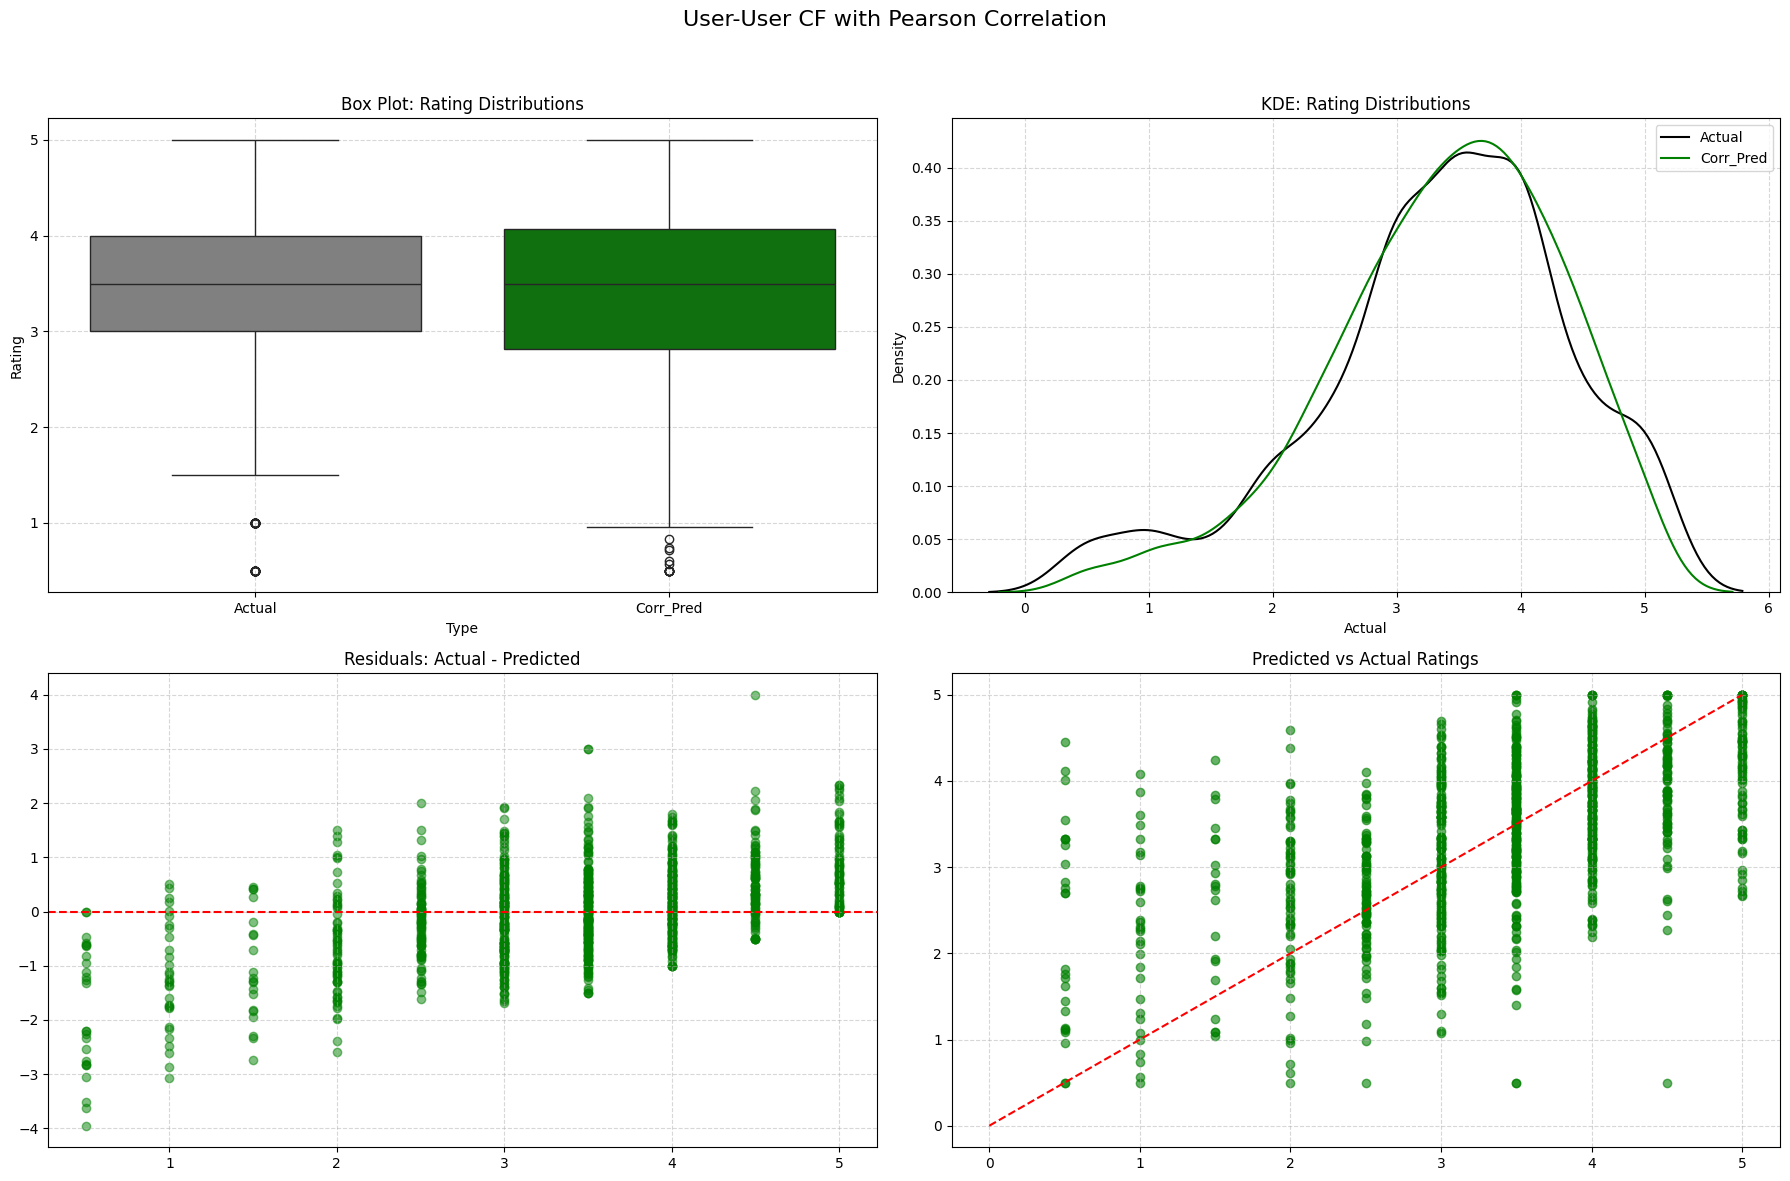

In [15]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load and Preprocess ---
stratified_df['genres'] = stratified_df['genres'].fillna('')

# Train-Test Split
train_ratings = stratified_df.sample(frac=0.8, random_state=42)
test_ratings = stratified_df.drop(train_ratings.index)

# User-Item Matrix
user_item_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')

# --- Step 2: Compute Correlation-Based User-User Similarity ---
user_user_sim_corr = user_item_matrix.T.corr(method='pearson', min_periods=5)

# --- Step 3: Compute Rating Statistics for Bias Correction ---
global_mean = train_ratings['rating'].mean()
item_means = train_ratings.groupby('movieId')['rating'].mean()
user_means = train_ratings.groupby('userId')['rating'].mean()

# --- Step 4: Define Correlation-Based Prediction Function ---
def predict_user_user_corr(uid, mid):
    if mid not in user_item_matrix.columns or uid not in user_user_sim_corr.index:
        return global_mean

    sims = user_user_sim_corr.loc[uid].drop(uid, errors='ignore')
    user_ratings = user_item_matrix[mid].dropna()
    sims = sims.loc[sims.index.intersection(user_ratings.index)]

    if sims.empty:
        return user_means.get(uid, global_mean) + item_means.get(mid, global_mean) - global_mean

    ratings = user_ratings[sims.index]
    weights = sims / sims.abs().sum()
    residuals = ratings - user_means[sims.index]
    weighted_sum = (weights * residuals).sum()

    user_bias = user_means.get(uid, global_mean) - global_mean
    item_bias = item_means.get(mid, global_mean) - global_mean

    return np.clip(global_mean + user_bias + item_bias + weighted_sum, 0.5, 5.0)

# --- Step 5: Parallel Predictions ---
def predict_row(row):
    uid, mid, actual = row['userId'], row['movieId'], row['rating']
    pred = predict_user_user_corr(uid, mid)
    return [uid, mid, actual, pred]

results_corr = Parallel(n_jobs=-1)(
    delayed(predict_row)(row) for _, row in test_ratings.iterrows()
)
viz_df_corr = pd.DataFrame(results_corr, columns=['userId', 'movieId', 'Actual', 'Corr_Pred'])

# --- Step 6: Evaluation ---
rmse = np.sqrt(mean_squared_error(viz_df_corr['Actual'], viz_df_corr['Corr_Pred']))
mae = mean_absolute_error(viz_df_corr['Actual'], viz_df_corr['Corr_Pred'])
r2 = r2_score(viz_df_corr['Actual'], viz_df_corr['Corr_Pred'])

print("\nEvaluation: User-User CF with Correlation Similarity")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- Step 7: Visualization ---
viz_sample = viz_df_corr.sample(n=min(1000, len(viz_df_corr)), random_state=42)

fig, axs = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle("User-User CF with Pearson Correlation", fontsize=16)

# Box Plot
sns.boxplot(data=viz_sample.melt(id_vars=['userId', 'movieId'], value_vars=['Actual', 'Corr_Pred'],
                                  var_name='Type', value_name='Rating'),
            x='Type', y='Rating', ax=axs[0, 0], palette={'Actual': 'gray', 'Corr_Pred': 'green'})
axs[0, 0].set_title('Box Plot: Rating Distributions')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)

# KDE Plot
sns.kdeplot(viz_sample['Actual'], label='Actual', color='black', ax=axs[0, 1])
sns.kdeplot(viz_sample['Corr_Pred'], label='Corr_Pred', color='green', ax=axs[0, 1])
axs[0, 1].set_title('KDE: Rating Distributions')
axs[0, 1].legend()
axs[0, 1].grid(True, linestyle='--', alpha=0.5)

# Residual Plot
residuals = viz_sample['Actual'] - viz_sample['Corr_Pred']
axs[1, 0].scatter(viz_sample['Actual'], residuals, alpha=0.5, color='green')
axs[1, 0].axhline(0, color='red', linestyle='--')
axs[1, 0].set_title('Residuals: Actual - Predicted')
axs[1, 0].grid(True, linestyle='--', alpha=0.5)

# Scatter: Predicted vs Actual
axs[1, 1].scatter(viz_sample['Actual'], viz_sample['Corr_Pred'], alpha=0.6, color='green')
axs[1, 1].plot([0, 5], [0, 5], 'r--')
axs[1, 1].set_title('Predicted vs Actual Ratings')
axs[1, 1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


***Comparison: User-User CF vs. Item-Item CF***

*User-User CF (Correlation-Based)*

RMSE: 0.9447,
MAE: 0.7146,
R²: 0.2054

*Item-Item CF (Correlation-Based)*

RMSE: 1.0043,
MAE: 0.7557,
R²: 0.1020

**Conclusion**
User-user correlation outperforms item-item correlation across all metrics: lower RMSE and MAE, and nearly double the R². This suggests user-user similarity using Pearson correlation is more effective in this dataset than item-item similarity using the same method.

**Why user-user performs better here:**

* **Better co-rating patterns among users:** Pearson correlation is highly sensitive to variance in co-ratings. Users may share more meaningful rating variance than items, making similarity more informative.
* **Item sparsity is more limiting:** Many items are rated by very few users, reducing the reliability of item-item correlation. This leads to noisy or flat similarities that skew predictions toward the mean.
* **Personalization edge:** User-user models are better at capturing idiosyncratic taste overlaps when similarity is meaningful, and Pearson correlation amplifies that signal—when data is sufficient.

Visuals support this. The user-user model shows tighter residual clustering and better alignment in the predicted vs. actual plot, with less severe under/overestimation than the item-item correlation model.

**In short:**
When using Pearson correlation, user-user CF delivers better predictive performance than item-item CF in this dataset.


# Content-Based Filtering

#### 1. Content-Based Movie Recommender Using Cosine Similarity on One-Hot Encoded Genre Vectors

This system predicts movie ratings using a content-based filtering approach. It compares genre similarity using cosine distance on one-hot (binary) genre vectors and evaluates three methods: GenreOnly, Uncentered, and Centered.

**Genre Representation (One-Hot Encoding)**
Each movie’s genre string is split by "|" and transformed into a binary vector.
If a movie belongs to a genre, that genre’s position in the vector is marked as 1, otherwise 0.
This yields a matrix where each row represents a movie and each column a genre.

**User Profile Construction**
Profiles summarize a user's preference over genres based on their rating history.

* *Uncentered Profile*
  The profile vector for a user is the average of the binary genre vectors of all movies they rated.
  $P_u = \frac{1}{|M_u|} \sum_{i \in M_u} G_i$

* *Centered Profile*
  Ratings are centered by subtracting the user’s mean rating. The genre vectors are weighted by this deviation.
  $P_u^{(c)} = \frac{1}{|M_u|} \sum_{i \in M_u} (r_{ui} - \bar{r}_u) \cdot G_i$

**Cosine Similarity and Rating Prediction**
To predict how much a user might like a movie, cosine similarity is computed between the user’s profile and the movie’s genre vector.
Similarity is converted into a predicted rating using:
$\hat{r}_{uj} = \mu_j + \alpha \cdot \text{cosine\_sim}(P_u, G_j)$
Where $\mu_j$ is the mean rating for movie $j$, and $\alpha$ is a scaling factor (set to 1.0). The prediction is clipped between 0.5 and 5.0.

**GenreOnly Prediction**
This method does not use any user information.
Instead, a movie’s rating is predicted as the average rating of the 10 most similar movies based on genre similarity.
$\hat{r}_j = \frac{1}{N} \sum_{k \in \text{Top-}N} \mu_k$

**5. Evaluation Metrics**
Model performance is assessed using:

* RMSE: Root Mean Squared Error
* MAE: Mean Absolute Error
* R² Score: Proportion of variance explained by the predictions

**Visualization**
Four visualizations are generated:

* A bar plot showing actual rating frequencies
* A box plot comparing predicted and actual rating distributions
* A KDE plot to visualize the density of predictions across methods
* A jittered residual plot showing the error (actual - predicted) across rating values

This approach allows for both personalization (via user profiles) and genre-driven similarity, enabling interpretable and scalable recommendations.


/tmp/ipython-input-4-306436471.py:58: RuntimeWarning: invalid value encountered in scalar divide
  sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))


Uncentered Prediction: RMSE=1.0462, MAE=0.7851, R²=0.0257
Centered Prediction: RMSE=1.0096, MAE=0.7790, R²=0.0926
GenreOnly Prediction: RMSE=1.1802, MAE=0.9737, R²=-0.2399


/tmp/ipython-input-4-306436471.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")


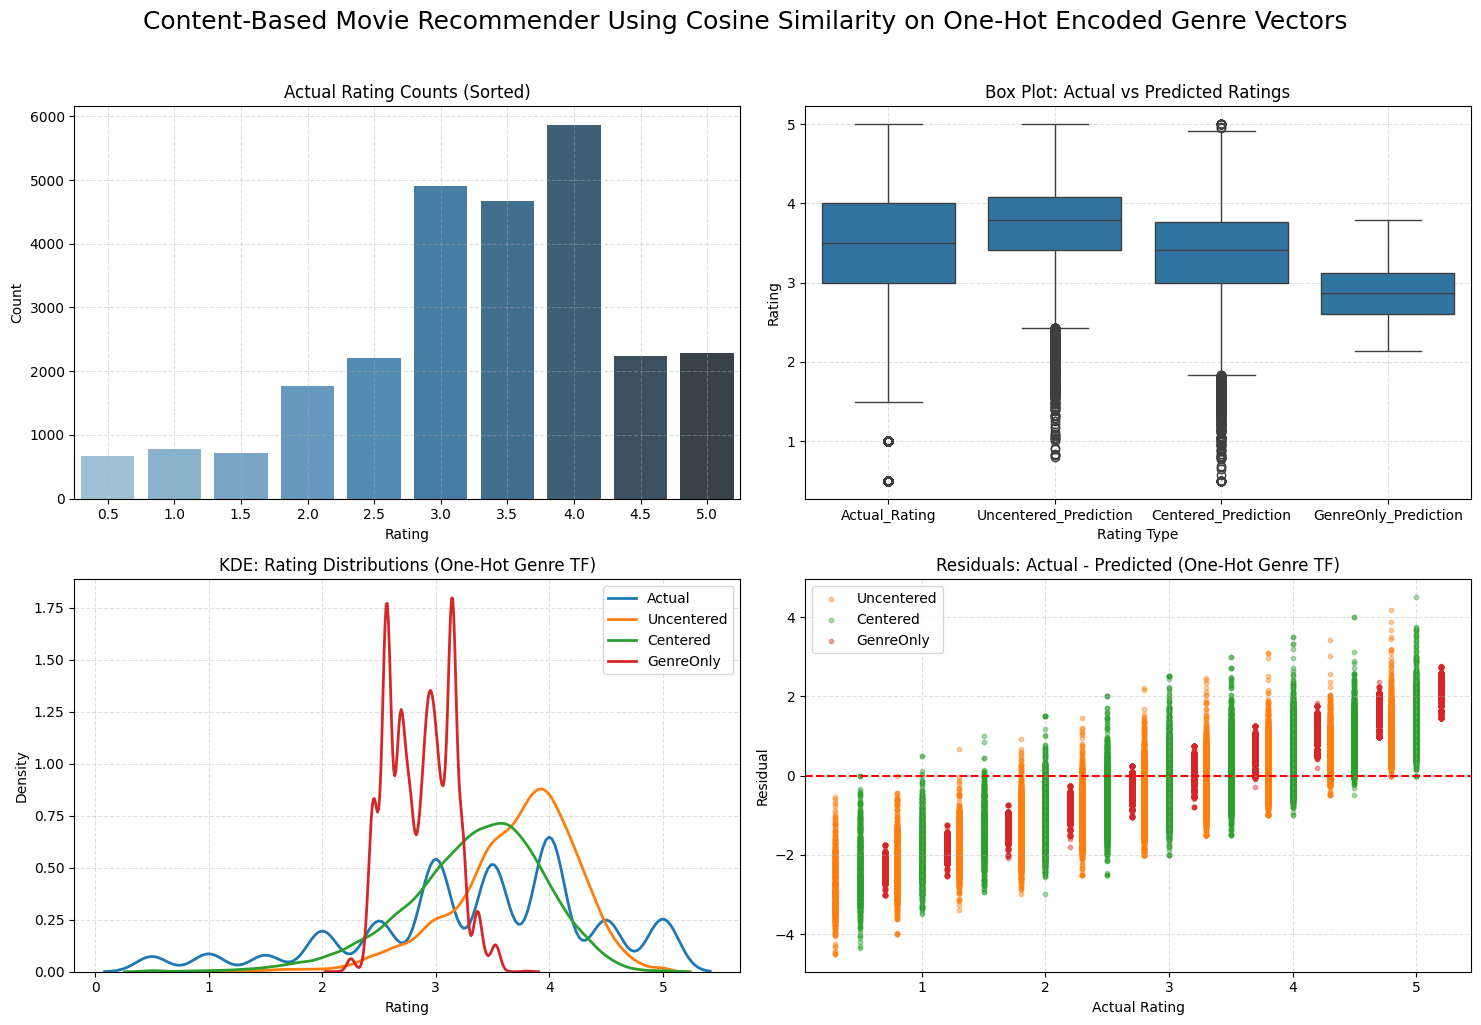

In [4]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Prepare Genre One-Hot Matrix ---
train_movie_ids = train_ratings['movieId'].unique()
movies = stratified_df[['movieId', 'genres']].drop_duplicates()
movies = movies[movies['movieId'].isin(train_movie_ids)].copy()
movies['genres'] = movies['genres'].fillna('')

genre_onehot = movies['genres'].str.get_dummies(sep='|')
genre_onehot.index = movies.index

# --- Step 2: Setup stats ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 3: User Profiles ---
def build_uncentered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[uid].dropna()
    matched = genre_onehot.loc[movies['movieId'].isin(rated_movies.index)]
    return matched.mean(axis=0).values if not matched.empty else None

def build_centered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated_movies = user_movie_matrix.loc[uid].dropna()
    matched = genre_onehot.loc[movies['movieId'].isin(rated_movies.index)]
    if matched.empty:
        return None
    centered = (rated_movies - rated_movies.mean()).values.reshape(-1, 1)
    return (centered.T @ matched.values / len(centered)).flatten()

# --- Step 4: Prediction Function with Item Bias ---
profile_cache = {}
def predict_rating(uid, mid, profile_type='uncentered'):
    if mid not in movie_means or uid not in user_movie_matrix.index:
        return global_mean
    if uid not in profile_cache:
        profile_cache[uid] = {
            "uncentered": build_uncentered_profile(uid),
            "centered": build_centered_profile(uid)
        }
    profile = profile_cache[uid][profile_type]
    if profile is None:
        return movie_means.get(mid, global_mean)
    if mid not in movies['movieId'].values:
        return movie_means.get(mid, global_mean)
    movie_vector = genre_onehot.loc[movies[movies['movieId'] == mid].index[0]].values
    sim = np.dot(profile, movie_vector) / (np.linalg.norm(profile) * np.linalg.norm(movie_vector))
    sim = 0 if np.isnan(sim) else sim

    item_bias = movie_means[mid] - global_mean
    return max(0.5, min(global_mean + item_bias + sim * 1.0, 5.0))

# --- Step 5: Predict on Test Set ---
true_ratings, pred_uncentered, pred_centered = [], [], []
for _, row in test_ratings.iterrows():
    uid, mid = row['userId'], row['movieId']
    if uid not in user_movie_matrix.index or mid not in movie_means:
        continue
    if build_uncentered_profile(uid) is None or build_centered_profile(uid) is None:
        continue
    true_ratings.append(row['rating'])
    pred_uncentered.append(predict_rating(uid, mid, 'uncentered'))
    pred_centered.append(predict_rating(uid, mid, 'centered'))

viz_df = pd.DataFrame({
    'Actual_Rating': true_ratings,
    'Uncentered_Prediction': pred_uncentered,
    'Centered_Prediction': pred_centered
})

# --- Step 6: Genre-Only Predictions ---
cos_sim_matrix = cosine_similarity(genre_onehot)
movie_ids = movies['movieId']
genre_only_preds = []
for i, mid in enumerate(movie_ids):
    if mid not in movie_means:
        genre_only_preds.append(global_mean)
        continue
    sim_scores = cos_sim_matrix[i]
    top_n_idx = np.argsort(sim_scores)[::-1][1:11]
    neighbor_ids = movie_ids.iloc[top_n_idx]
    neighbor_ratings = movie_means[movie_means.index.isin(neighbor_ids)]
    genre_only_preds.append(neighbor_ratings.mean() if not neighbor_ratings.empty else global_mean)

genre_only_df = pd.DataFrame({'movieId': movie_ids, 'GenreOnly_Prediction': genre_only_preds})
test_subset = test_ratings[test_ratings['userId'].isin(user_movie_matrix.index)]
merged_genre_df = pd.merge(test_subset, genre_only_df, on='movieId')
viz_df = pd.merge(viz_df, merged_genre_df[['userId', 'movieId', 'GenreOnly_Prediction']],
                  left_index=True, right_index=True)

viz_df_clean = viz_df.dropna()

# --- Step 7: Evaluation ---
for name in ['Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction']:
    rmse = np.sqrt(mean_squared_error(viz_df_clean['Actual_Rating'], viz_df_clean[name]))
    mae = mean_absolute_error(viz_df_clean['Actual_Rating'], viz_df_clean[name])
    r2 = r2_score(viz_df_clean['Actual_Rating'], viz_df_clean[name])
    print(f"{name.replace('_', ' ')}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 8: Evaluation Plots ---
viz_df_clean['Residual_Uncentered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Uncentered_Prediction']
viz_df_clean['Residual_Centered'] = viz_df_clean['Actual_Rating'] - viz_df_clean['Centered_Prediction']
viz_df_clean['Residual_GenreOnly'] = viz_df_clean['Actual_Rating'] - viz_df_clean['GenreOnly_Prediction']

box_df = viz_df_clean.melt(
    value_vars=['Actual_Rating', 'Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- Plot 1: Bar Plot ---
rating_counts = viz_df_clean['Actual_Rating'].value_counts().sort_values(ascending=False)
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title("Actual Rating Counts (Sorted)")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

# --- Plot 2: Box Plot ---
sns.boxplot(x='Rating_Type', y='Rating', data=box_df, ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# --- Plot 3: KDE ---
sns.kdeplot(viz_df_clean['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2, color='C0')
sns.kdeplot(viz_df_clean['Uncentered_Prediction'], label='Uncentered', ax=axes[1, 0], linewidth=2, color='C1')
sns.kdeplot(viz_df_clean['Centered_Prediction'], label='Centered', ax=axes[1, 0], linewidth=2, color='C2')
sns.kdeplot(viz_df_clean['GenreOnly_Prediction'], label='GenreOnly', ax=axes[1, 0], linewidth=2, color='C3')
axes[1, 0].set_title("KDE: Rating Distributions (One-Hot Genre TF)")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# --- Plot 4: Residuals ---
offsets = {'Residual_Uncentered': -0.2, 'Residual_Centered': 0, 'Residual_GenreOnly': 0.2}
colors = {'Residual_Uncentered': 'C1', 'Residual_Centered': 'C2', 'Residual_GenreOnly': 'C3'}

axes[1, 1].cla()
for key in offsets:
    x_vals = viz_df_clean['Actual_Rating'] + offsets[key]
    y_vals = viz_df_clean[key]
    axes[1, 1].scatter(x_vals, y_vals, alpha=0.4, label=key.replace("Residual_", ""), s=10, color=colors[key])

axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (One-Hot Genre TF)")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Content-Based Movie Recommender Using Cosine Similarity on One-Hot Encoded Genre Vectors", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


***Analysis: Content-Based Movie Recommender Using One-Hot Encoded Genre Vectors (Cosine Similarity)***

**Model Performance (Metrics):**

* *Uncentered Prediction:* RMSE=1.0462, MAE=0.7851, R²=0.0257
* *Centered Prediction:* RMSE=1.0096, MAE=0.7790, R²=0.0926
* *GenreOnly Prediction:* RMSE=1.1802, MAE=0.9737, R²=-0.2399

The centered model shows the best predictive performance overall with the lowest RMSE/MAE and highest (though still modest) R². The GenreOnly model performs worst, with a negative R², indicating it underperforms compared to simply predicting the mean.

**Rating Distribution and Box Plot (Top Right):**
All predicted distributions are slightly more compressed than the actual ratings, but:

* *Centered Prediction* aligns more closely with the true distribution than *Uncentered* or *GenreOnly*.
* *GenreOnly* underpredicts higher ratings and overpredicts lower ratings, which is also seen in its narrower box and lower median.

**KDE Plot (Bottom Left):**

* *Actual* ratings show a spread with a peak near 4.0.
* *Uncentered* and *Centered* KDEs approximate this shape, with the *Centered* line more closely matching the distribution of actual ratings.
* *GenreOnly* shows unrealistic density spikes around 3.0, confirming it's less effective at capturing true rating variation.

**Residuals (Bottom Right):**

* *Centered* predictions yield tighter residuals around 0 across all rating values, reinforcing its superior accuracy.
* *Uncentered* predictions show a similar pattern but with more dispersion.
* *GenreOnly* residuals are consistently biased low across most rating levels—indicative of its poor adaptability to user preferences.

**Conclusion:**
Centering user profiles yields notable improvements in performance and error consistency. The EDA plots (box, KDE, and residuals) all support the metric findings—centered profiles better capture rating behavior. The GenreOnly model lacks personalization and performs poorly, both statistically and visually.


#### 2. Jaccard-Based and Genre-Only Recommender Systems

**Data Preparation**
Movie metadata and user ratings are loaded from external CSV files. Genres are processed using one-hot encoding to create a binary matrix indicating the presence or absence of each genre per movie. The ratings data is split into training and testing sets (80/20 split). Global and per-movie average ratings are computed to support baseline predictions.

**User Profile Construction**
Two types of user profiles are constructed based on the genre vectors of movies each user has rated:

* *Uncentered Profile*: Averages the binary genre vectors of all movies rated by a user to reflect their general genre preferences.
* *Centered Profile*: First centers the user's ratings by subtracting their mean rating, then computes a weighted average of genre vectors, emphasizing deviations from the user’s personal baseline.

**Jaccard-Based Prediction**
Each user’s profile is compared to the genre vector of the target movie using Jaccard similarity. The predicted rating is computed as the sum of the movie’s average rating and the scaled similarity score. Predictions are bounded between 0.5 and 5.0 to align with rating limits.

**Genre-Only Prediction**
No user history is used. Instead, cosine similarity is calculated between the genre vector of a target movie and all others. The predicted rating is the average rating of the top 10 most similar movies that have known ratings in the training data.

**Evaluation and Visualization**
Performance metrics include RMSE, MAE, and R² for each method. Residuals are computed to assess prediction error patterns. Visualizations include:

* A bar plot showing actual rating distribution
* A box plot comparing actual vs predicted ratings for all methods
* A KDE plot showing rating distribution curves for each method
* A residual scatter plot with horizontal jitter to distinguish the methods

This methodology supports a comprehensive evaluation of personalized (uncentered and centered) and non-personalized (genre-only) content-based recommendation strategies using genre similarity.


Uncentered Prediction: RMSE=0.9834, MAE=0.7407, R²=0.1392
Centered Prediction: RMSE=0.9850, MAE=0.7444, R²=0.1364
GenreOnly Prediction: RMSE=1.1742, MAE=0.9672, R²=-0.2274


/tmp/ipython-input-5-779477926.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")


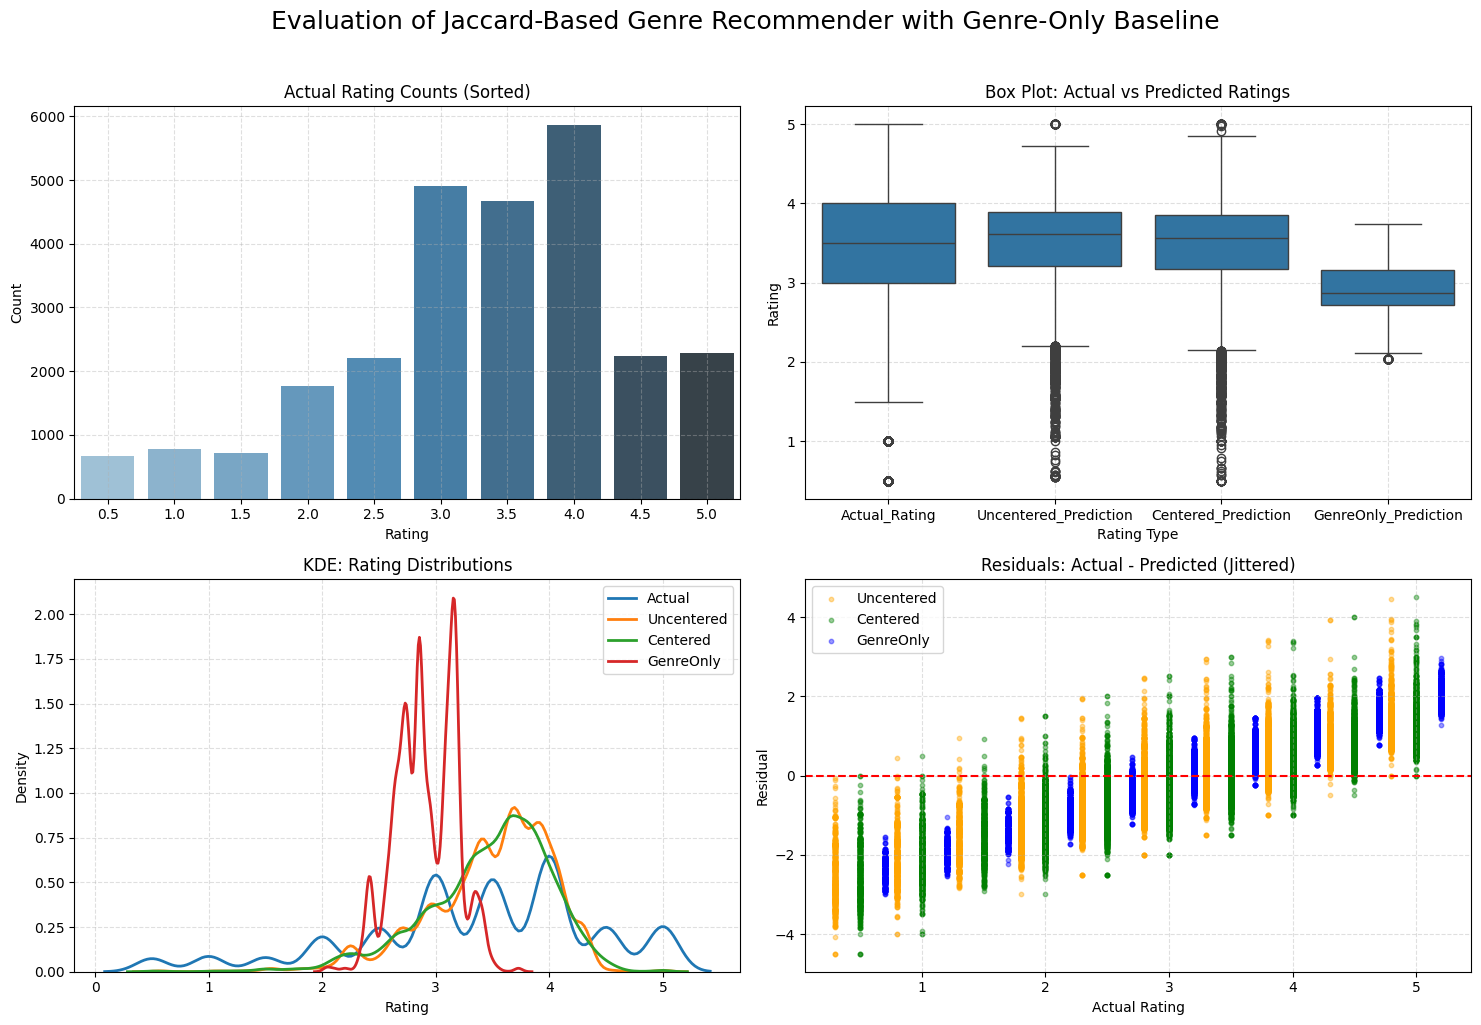

In [5]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity

train_movie_ids = train_ratings['movieId'].unique()
train_movies = movies[movies['movieId'].isin(train_movie_ids)].copy().reset_index(drop=True)

# --- Step 3: Multi-hot Genre Matrix (Training Set Only) ---
train_movies['genres'] = train_movies['genres'].fillna('')
genre_matrix = train_movies['genres'].str.get_dummies(sep='|')

# --- Step 4: Rating Stats ---
user_movie_matrix = train_ratings.pivot(index='userId', columns='movieId', values='rating')
global_mean = train_ratings['rating'].mean()
movie_means = train_ratings.groupby('movieId')['rating'].mean()

# --- Step 5a: User Profile (Uncentered) ---
def build_uncentered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated = user_movie_matrix.loc[uid].dropna()
    matched = genre_matrix.loc[train_movies['movieId'].isin(rated.index)]
    if matched.empty:
        return None
    return matched.mean(axis=0).values

# --- Step 5b: User Profile (Centered) ---
def build_centered_profile(uid):
    if uid not in user_movie_matrix.index:
        return None
    rated = user_movie_matrix.loc[uid].dropna()
    matched = genre_matrix.loc[train_movies['movieId'].isin(rated.index)]
    if matched.empty:
        return None
    centered = (rated - rated.mean()).values.reshape(-1, 1)
    return (centered.T @ matched.values / len(centered)).flatten()

# --- Step 6: Jaccard Prediction ---
profile_cache = {}

def jaccard_similarity(vec1, vec2):
    return jaccard_score(vec1 > 0, vec2 > 0)

def predict_rating(uid, mid, profile_type='uncentered'):
    if uid not in user_movie_matrix.index or mid not in movie_means:
        return global_mean
    if uid not in profile_cache:
        profile_cache[uid] = {
            "uncentered": build_uncentered_profile(uid),
            "centered": build_centered_profile(uid)
        }
    profile = profile_cache[uid][profile_type]
    if profile is None:
        return movie_means.get(mid, global_mean)

    genre_idx = train_movies[train_movies['movieId'] == mid].index
    if genre_idx.empty:
        return movie_means.get(mid, global_mean)

    movie_vector = genre_matrix.iloc[genre_idx[0]].values
    sim = jaccard_similarity(profile, movie_vector)
    baseline = movie_means.get(mid, global_mean)
    pred = baseline + sim * 1.0
    return max(0.5, min(pred, 5.0))

# --- Step 7: Predictions ---
true_ratings, pred_uncentered, pred_centered = [], [], []

for _, row in test_ratings.iterrows():
    uid, mid = row['userId'], row['movieId']
    if uid not in user_movie_matrix.index or mid not in movie_means:
        continue
    if build_uncentered_profile(uid) is None or build_centered_profile(uid) is None:
        continue
    true_ratings.append(row['rating'])
    pred_uncentered.append(predict_rating(uid, mid, 'uncentered'))
    pred_centered.append(predict_rating(uid, mid, 'centered'))

# --- Step 8: DataFrame ---
viz_df = pd.DataFrame({
    'Actual_Rating': true_ratings,
    'Uncentered_Prediction': pred_uncentered,
    'Centered_Prediction': pred_centered
})

# --- Step 9: Genre-Only Prediction ---
cos_sim_matrix = cosine_similarity(genre_matrix)
genre_only_preds = []

for mid in test_ratings['movieId']:
    if mid not in movie_means:
        genre_only_preds.append(global_mean)
        continue
    genre_idx = train_movies[train_movies['movieId'] == mid].index
    if genre_idx.empty:
        genre_only_preds.append(global_mean)
        continue
    sim_scores = cos_sim_matrix[genre_idx[0]]
    sim_scores[genre_idx[0]] = 0
    top_n_idx = np.argsort(sim_scores)[::-1][:10]
    neighbor_ids = train_movies['movieId'].iloc[top_n_idx]
    neighbor_ratings = movie_means[movie_means.index.isin(neighbor_ids)]
    genre_only_preds.append(neighbor_ratings.mean() if not neighbor_ratings.empty else global_mean)

viz_df['GenreOnly_Prediction'] = genre_only_preds[:len(viz_df)]

# --- Step 10: Evaluation ---
for name in ['Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction']:
    rmse = np.sqrt(mean_squared_error(viz_df['Actual_Rating'], viz_df[name]))
    mae = mean_absolute_error(viz_df['Actual_Rating'], viz_df[name])
    r2 = r2_score(viz_df['Actual_Rating'], viz_df[name])
    print(f"{name.replace('_', ' ')}: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# --- Step 11: Residuals ---
viz_df['Residual_Uncentered'] = viz_df['Actual_Rating'] - viz_df['Uncentered_Prediction']
viz_df['Residual_Centered'] = viz_df['Actual_Rating'] - viz_df['Centered_Prediction']
viz_df['Residual_GenreOnly'] = viz_df['Actual_Rating'] - viz_df['GenreOnly_Prediction']

# --- Step 12: Box Plot Prep ---
box_df = viz_df.melt(
    value_vars=['Actual_Rating', 'Uncentered_Prediction', 'Centered_Prediction', 'GenreOnly_Prediction'],
    var_name='Rating_Type',
    value_name='Rating'
)

# --- Step 13: Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Bar Plot
rating_counts = viz_df['Actual_Rating'].value_counts().sort_values(ascending=False)
sns.barplot(x=rating_counts.index, y=rating_counts.values, ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title("Actual Rating Counts (Sorted)")
axes[0, 0].set_xlabel("Rating")
axes[0, 0].set_ylabel("Count")
axes[0, 0].grid(True, linestyle='--', alpha=0.4)

# Box Plot
sns.boxplot(x='Rating_Type', y='Rating', data=box_df, ax=axes[0, 1])
axes[0, 1].set_title("Box Plot: Actual vs Predicted Ratings")
axes[0, 1].set_xlabel("Rating Type")
axes[0, 1].set_ylabel("Rating")
axes[0, 1].grid(True, linestyle='--', alpha=0.4)

# KDE Plot
sns.kdeplot(viz_df['Actual_Rating'], label='Actual', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['Uncentered_Prediction'], label='Uncentered', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['Centered_Prediction'], label='Centered', ax=axes[1, 0], linewidth=2)
sns.kdeplot(viz_df['GenreOnly_Prediction'], label='GenreOnly', ax=axes[1, 0], linewidth=2)
axes[1, 0].set_title("KDE: Rating Distributions")
axes[1, 0].set_xlabel("Rating")
axes[1, 0].set_ylabel("Density")
axes[1, 0].legend()
axes[1, 0].grid(True, linestyle='--', alpha=0.4)

# Residual Plot
offsets = {'Residual_Uncentered': -0.2, 'Residual_Centered': 0, 'Residual_GenreOnly': 0.2}
colors = {'Residual_Uncentered': 'orange', 'Residual_Centered': 'green', 'Residual_GenreOnly': 'blue'}
for key in offsets:
    x_vals = viz_df['Actual_Rating'] + offsets[key]
    y_vals = viz_df[key]
    axes[1, 1].scatter(x_vals, y_vals, alpha=0.4, label=key.replace("Residual_", ""), s=10, color=colors[key])
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals: Actual - Predicted (Jittered)")
axes[1, 1].set_xlabel("Actual Rating")
axes[1, 1].set_ylabel("Residual")
axes[1, 1].legend()
axes[1, 1].grid(True, linestyle='--', alpha=0.4)

# Layout
plt.suptitle("Evaluation of Jaccard-Based Genre Recommender with Genre-Only Baseline", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


**Jaccard outperforms Cosine** across all metrics due to its superior handling of binary, sparse one-hot genre vectors—an advantage clearly supported by EDA insights.

* It delivers **lower RMSE/MAE** and **higher R²**, showing more accurate and better-fitting predictions than Cosine.
* **Rating Distributions (KDE):** Jaccard’s centered predictions closely follow the actual rating curve, whereas Cosine introduces broader or spiky densities, particularly in genre-only mode.
* **Box Plots:** Jaccard predictions are more compact with fewer outliers, reflecting greater prediction stability.
* **Residuals:** Jaccard exhibits tighter, more symmetric residual bands across all rating levels. Cosine shows more scatter and skew, especially at rating extremes.

**Conclusion:** Jaccard’s set-based similarity is semantically aligned with one-hot encoded genres, avoiding Cosine’s sensitivity to vector magnitude and sparsity. This structural match translates into measurable performance improvements and is visibly confirmed through the EDA.


# Model Comparison Summary: EDA-Driven Insights on Predictive Accuracy and Robustness

The **Jaccard-based genre model** is the best overall. It aligns perfectly with the binary, sparse nature of one-hot genre vectors, prioritizing shared genre presence without being distorted by magnitude or sparsity—unlike Cosine.

**User-User CF with Shrinkage** performs best among collaborative filtering models. It stabilizes similarity estimates for users with few co-ratings, reducing volatility and overfitting. EDA shows tighter residuals and better alignment with actual ratings.

The **worst performer is Cosine-based genre prediction**, which is sensitive to vector length and sparsity, leading to noisy predictions. KDE plots reveal unnatural density spikes, and residuals are more scattered compared to Jaccard.

**EDA Insights:**

* **KDE plots** show Jaccard and Shrinkage predictions closely track the true rating curve.
* **Box plots** highlight reduced variance and fewer outliers for Jaccard and Shrinkage.
* **Residual plots** confirm Cosine’s weakness with broader, asymmetric residuals.

**Conclusion:**
For content-based filtering, use Jaccard. For user-user CF, apply Shrinkage. Both choices are supported by error distribution and density insights from the EDA.
